In [2]:
# basic
import math
from math import pi
import numpy as np
import pandas as pd
from os import path
from PIL import Image
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# stats
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

monster_df = pd.read_csv('../data/processed/1_Monster_Dataset.csv')

monster_df.drop(columns={"Monster Name.1","Unnamed: 0"},axis=1, inplace=True)
monster_df.head()

Monster Name    Size       Type     Alignment  \
0   Adult Green Dragon    Huge     dragon   lawful evil   
1  Adult Silver Dragon    Huge     dragon   lawful good   
2   Adult White Dragon    Huge     dragon  chaotic evil   
3        Air Elemental   Large  elemental       neutral   
4                  Ape  Medium      beast     unaligned   

                                              Traits Reactions  Armor Class  \
0  ['Amphibious. The dragon can breathe air and w...    ['NA']           19   
1  ['Legendary Resistance (3/Day). If the dragon ...    ['NA']           19   
2  ["Ice Walk. The dragon can move across and cli...    ['NA']           18   
3  ["Air Form. The elemental can enter a hostile ...    ['NA']           15   
4                                              [nan]    ['NA']           12   

   Hit Points                                           Speed  Challenge  ...  \
0         207                 40 ft., fly 80 ft., swim 40 ft.       15.0  ...   
1         243                              40 ft., fly 80 ft.       16.0  ...   
2         200  40 ft., burrow 30 ft., fly 80 ft., swim 40 ft.       13.0  ...   
3          90                       0 ft., fly 90 ft. (hover)        5.0  ...   
4          19                            30 ft., climb 30 ft.        0.5  ...   

   Damage Vulnerabilities  Spellcaster  Magic Resistance  \
0                       0          0.0               0.0   
1                       0          0.0               0.0   
2                       0          0.0               0.0   
3                       0          0.0               0.0   
4                       0          0.0               0.0   

   Legendary Resistance  Regeneration  Undead Fortitude  Pack Tactics  \
0                   1.0           0.0               0.0           0.0   
1                   1.0           0.0               0.0           0.0   
2                   1.0           0.0               0.0           0.0   
3                   0.0           0.0               0.0           0.0   
4                   0.0           0.0               0.0           0.0   

  Damage Transfer Angelic Weapons Charge  
0             0.0             0.0    0.0  
1             0.0             0.0    0.0  
2             0.0             0.0    0.0  
3             0.0             0.0    0.0  
4             0.0             0.0    0.0  

[5 rows x 55 columns]

## Monster Stat Block Insights

### Dataset: Numerics Stats only

C:\Users\ingal\AppData\Local\Temp\ipykernel_7400\1096787799.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  monster_df.iloc[:,0:29].hist(ax=ax);


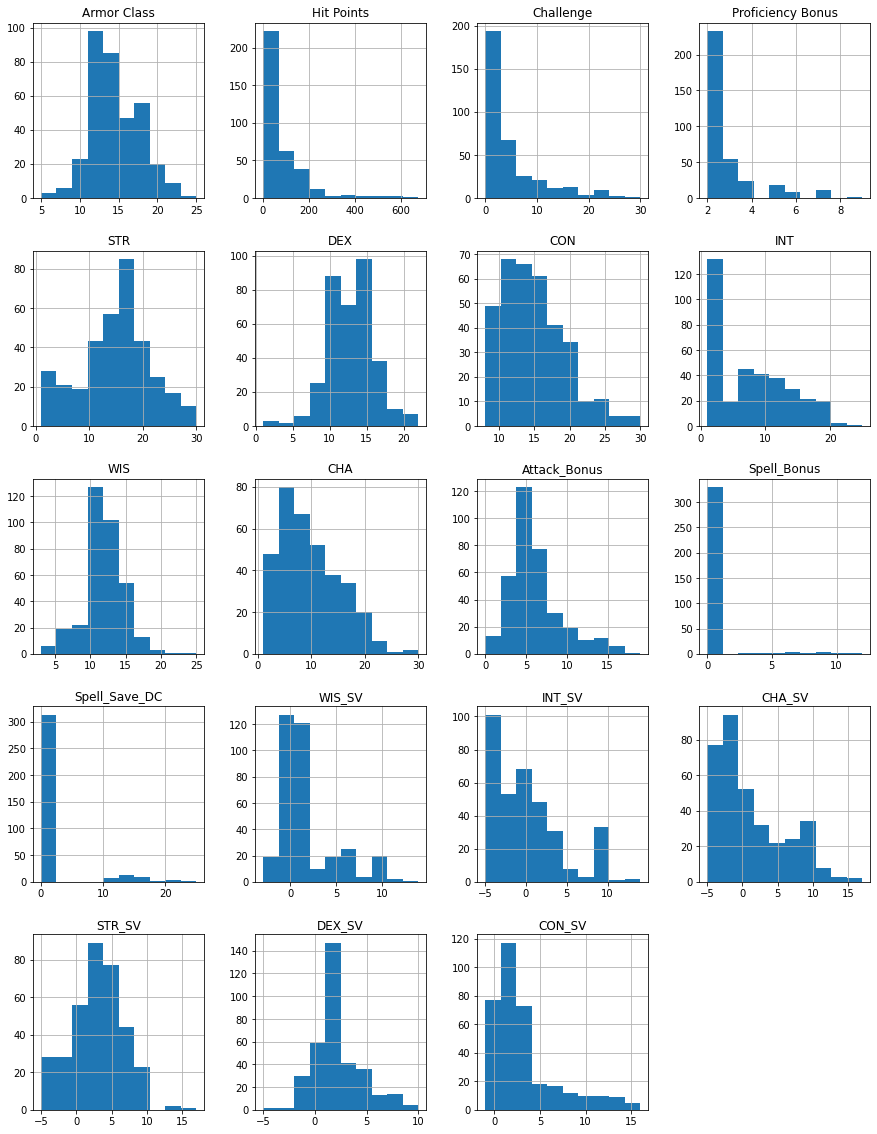

In [2]:
#Trim dataset quick histogram to necessary stats
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
monster_df.iloc[:,0:29].hist(ax=ax);

Based on the Challenge Rating and Hit points, we have a very skewed dataset. That's totally ok! Most campaigns don't go past lvl 15 usually, so it makes sense wizards would have more lower CR monsters. Also, just rationally, a world with just as many high CR monsters sounds scary AF. 

However, I can see Armor class seems to follow a somewhat normal distributions, same with Dex, STR, and WIS. CHA, CON, INT are also very right tail skewed. We expect this from Proficiency bonus since that goes hand in hand with Challenege rating.

The right-skewed natures makes sense, considering there are more monsters at lower-levels

### Comparing stats vs stats using scatter plots

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


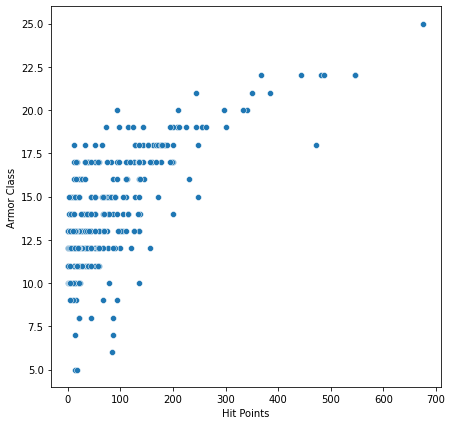

In [3]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Hit Points"], monster_df["Armor Class"])

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 504x504 with 0 Axes>

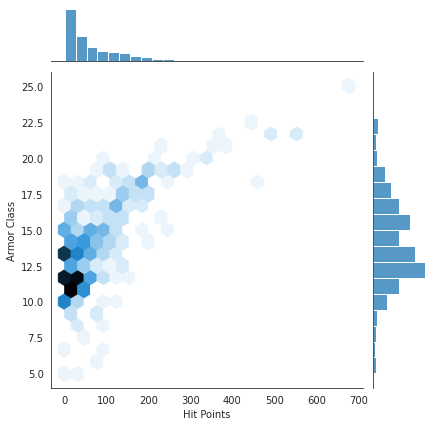

In [4]:
fig = plt.figure(figsize = (7,7));
with sns.axes_style("white"):
    sns.jointplot(monster_df["Hit Points"], monster_df['Armor Class'], kind='hex');

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


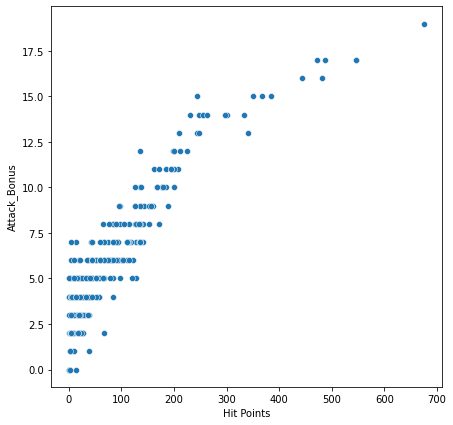

In [5]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Hit Points"], monster_df["Attack_Bonus"])

## Question 2.A: How do the monster’s stats correlate to the Challenge Rating System?

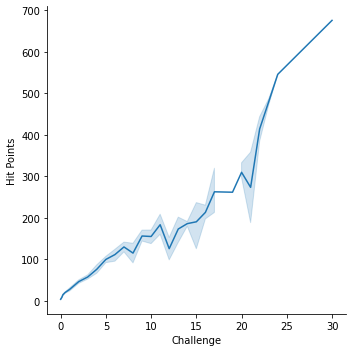

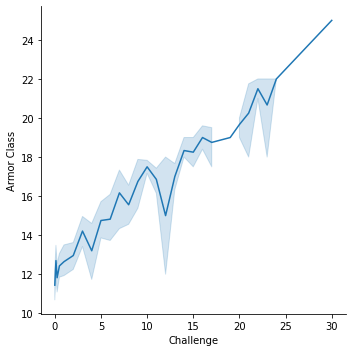

In [6]:
hitpoint_line = sns.relplot(x = "Challenge", y = "Hit Points", kind = "line", data = monster_df)
armor_line =  sns.relplot(x = "Challenge", y = "Armor Class", kind = "line", data = monster_df)

We can see that both hitpoints and armor class have a strong positive correlation with challenge rating

### Saving Throw vs. Challenge Ratings

In [7]:
# Saving Throw DataFrame
saving_throw_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_df.columns = ['Challenge','Saving Throw', 'value']

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


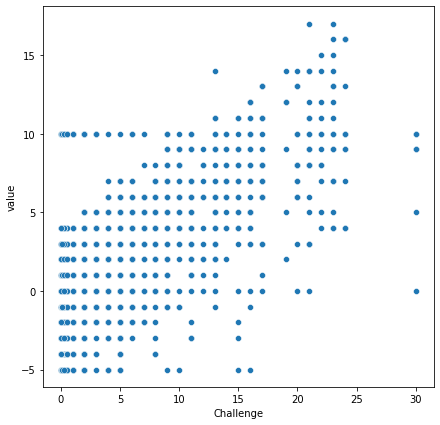

In [8]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(saving_throw_df["Challenge"], saving_throw_df["value"])

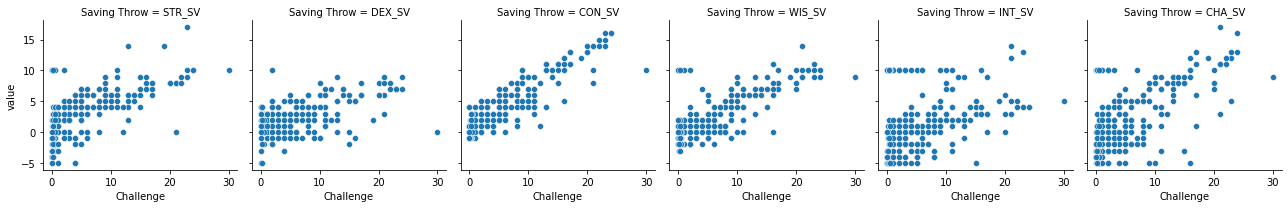

In [9]:
g = sns.FacetGrid(saving_throw_df, col="Saving Throw")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

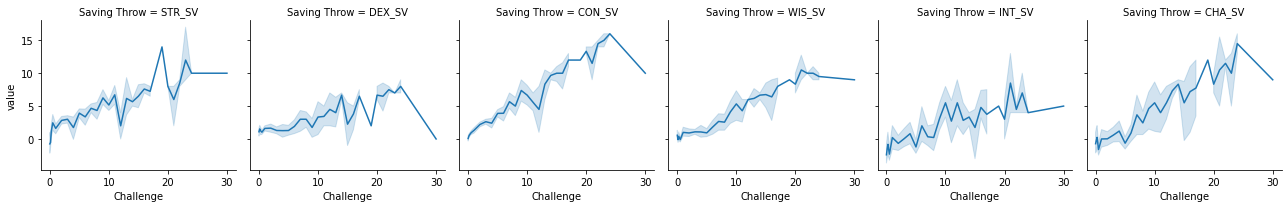

In [10]:
g = sns.FacetGrid(saving_throw_df, col="Saving Throw")
g.map_dataframe(sns.lineplot, x="Challenge", y="value")

Out of all the saving throws, it looks like Dexerity has the least correlation and also the lowest value at higher levels. However, they all appear to have a correlation to challenge rating. The interesting dropoff at 30 CR is because our dataset only has one 30 CR monster, the tarrasque.

### Stats vs. Challenge Ratings

In [11]:
#Stats dataframe
stats_challenge_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_challenge_df.columns = ['Challenge','Stats', 'value']

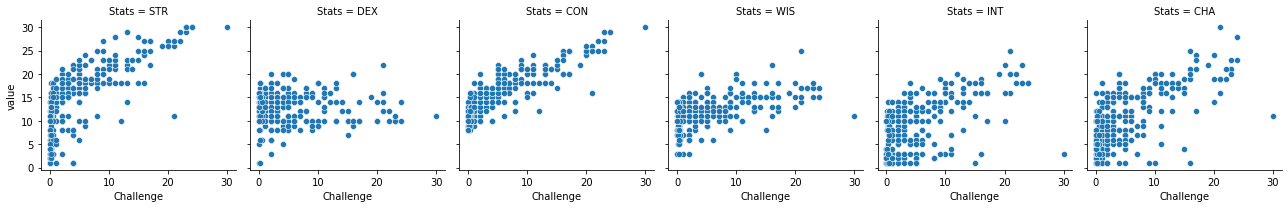

In [12]:
g = sns.FacetGrid(stats_challenge_df, col="Stats")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

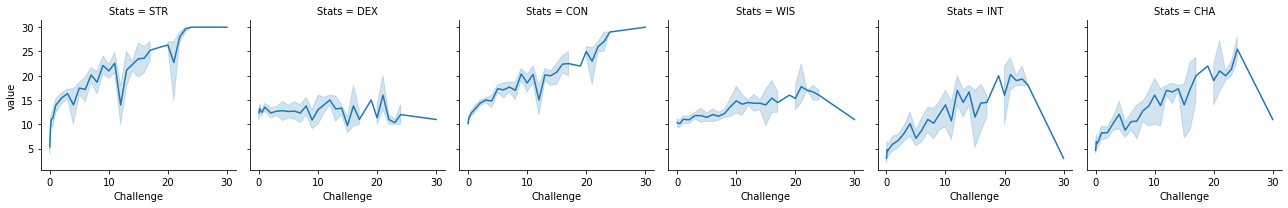

In [13]:
g = sns.FacetGrid(stats_challenge_df, col="Stats")
g.map_dataframe(sns.lineplot, x="Challenge", y="value")

With our main stats, we can see that Dex ad WIS have a pretty low correlation to challenge rating, Wisom does seem to have a slight correlation, but STR, CON, INT, and CHA all have a much stronger correlation.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


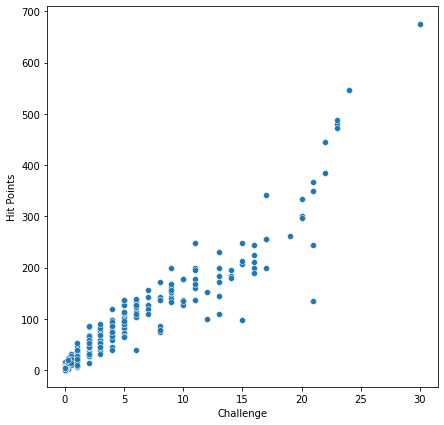

In [14]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Hit Points"]);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


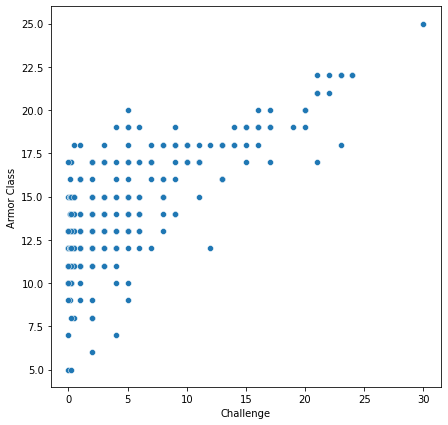

In [15]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Armor Class"]);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


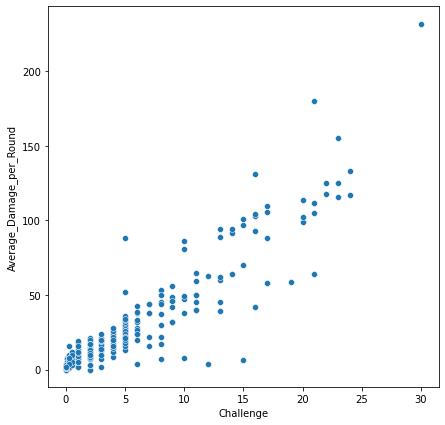

In [16]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Average_Damage_per_Round"])

As we said earlier, Hit Points and Armor Class have strong correlations, but additional we see that Average Damage does as well. Over all this means that Challenge Rating is a strong contender for one of our inputs.

### Resistences, Immunities

In [17]:
#dataframe
resistence_immunity_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'Damage Resistances', 'Damage Immunities', 'Condition Immunities', 'Damage Vulnerabilities'])
resistence_immunity_df.columns = ['Challenge','Res_Immun', 'value']

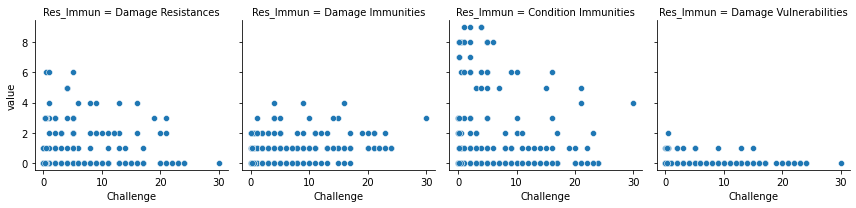

In [18]:
g = sns.FacetGrid(resistence_immunity_df, col="Res_Immun")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

Unexpectedly high number of resistences and immunites for the lower CRs. I also expected more of a positive correlation for these stats, it looks like lower level monsters can also have high immunities.

## Question 2.B: How do the Stats relate to each other? 

#### Dropping Columns not needed for analysis

In [19]:
monster_df_wordless = monster_df.drop(columns = {'Environment','Actions','Speed'},axis=1)

#### Encoding phrases, removing text and NaN for modeling

In [20]:
for indx, value in enumerate(monster_df_wordless['Legendary Actions']):
    if 'NA' in value:
        monster_df_wordless.loc[indx,'Legendary Actions'] = 0
    else:
        monster_df_wordless.loc[indx,'Legendary Actions'] = 1

In [21]:
for indx, value in enumerate(monster_df_wordless['Reactions']):
    if 'NA' in value:
        monster_df_wordless.loc[indx,'Reactions'] = 0
    else:
        monster_df_wordless.loc[indx,'Reactions'] = 1

In [22]:
for indx, value in enumerate(monster_df_wordless['Traits']):
    if 'nan' in value:
        monster_df_wordless.loc[indx,'Traits'] = 0
    else:
        monster_df_wordless.loc[indx,'Traits'] = 1

In [24]:
monster_df_wordless.describe().transpose()

count       mean        std  min    25%   50%  \
Armor Class               348.0  13.985632   3.155403  5.0  12.00  13.0   
Hit Points                348.0  78.399425  96.670352  1.0  17.00  45.0   
Challenge                 348.0   4.346624   5.711322  0.0   0.25   2.0   
Proficiency Bonus         348.0   2.712644   1.296486  2.0   2.00   2.0   
STR                       348.0  14.951149   6.705018  1.0  11.00  16.0   
DEX                       348.0  12.706897   3.078279  1.0  10.00  13.0   
CON                       348.0  14.991379   4.385913  8.0  12.00  14.0   
INT                       348.0   7.683908   5.673953  1.0   2.00   7.0   
WIS                       348.0  11.606322   2.896418  3.0  10.00  11.5   
CHA                       348.0   9.548851   5.780861  1.0   5.00   8.0   
Attack_Bonus              348.0   5.916667   3.425865  0.0   4.00   5.0   
Spell_Bonus               348.0   0.356322   1.635182  0.0   0.00   0.0   
Spell_Save_DC             348.0   1.500000   4.610163  0.0   0.00   0.0   
WIS_SV                    348.0   1.813218   3.052310 -3.0   0.00   1.0   
INT_SV                    348.0   0.051724   4.464741 -5.0  -4.00   0.0   
CHA_SV                    348.0   1.244253   4.827347 -5.0  -2.00   0.0   
STR_SV                    348.0   2.847701   3.634183 -5.0   0.75   3.0   
DEX_SV                    348.0   1.959770   2.306136 -5.0   0.00   2.0   
CON_SV                    348.0   3.183908   3.707703 -1.0   1.00   2.0   
Arctic                    348.0   0.091954   0.289377  0.0   0.00   0.0   
Coastal                   348.0   0.126437   0.332820  0.0   0.00   0.0   
Desert                    348.0   0.195402   0.397081  0.0   0.00   0.0   
Forest                    348.0   0.304598   0.460900  0.0   0.00   0.0   
Grassland                 348.0   0.212644   0.409767  0.0   0.00   0.0   
Hill                      348.0   0.224138   0.417614  0.0   0.00   0.0   
Mountain                  348.0   0.129310   0.336026  0.0   0.00   0.0   
NA                        348.0   0.178161   0.383199  0.0   0.00   0.0   
Swamp                     348.0   0.129310   0.336026  0.0   0.00   0.0   
Underdark                 348.0   0.229885   0.421365  0.0   0.00   0.0   
Underwater                348.0   0.060345   0.238467  0.0   0.00   0.0   
Urban                     348.0   0.218391   0.413749  0.0   0.00   0.0   
Average_Damage_per_Round  348.0  24.298851  32.164982  0.0   5.00  12.0   
Damage Resistances        348.0   0.525862   1.181958  0.0   0.00   0.0   
Damage Immunities         348.0   0.574713   0.836931  0.0   0.00   0.0   
Condition Immunities      348.0   1.163793   2.372795  0.0   0.00   0.0   
Damage Vulnerabilities    348.0   0.048851   0.228827  0.0   0.00   0.0   
Spellcaster               348.0   0.112069   0.315905  0.0   0.00   0.0   
Magic Resistance          348.0   0.100575   0.301198  0.0   0.00   0.0   
Legendary Resistance      348.0   0.066092   0.248800  0.0   0.00   0.0   
Regeneration              348.0   0.017241   0.130357  0.0   0.00   0.0   
Undead Fortitude          348.0   0.005747   0.075700  0.0   0.00   0.0   
Pack Tactics              348.0   0.051724   0.221788  0.0   0.00   0.0   
Damage Transfer           348.0   0.005747   0.075700  0.0   0.00   0.0   
Angelic Weapons           348.0   0.008621   0.092580  0.0   0.00   0.0   
Charge                    348.0   0.051724   0.221788  0.0   0.00   0.0   

                             75%    max  
Armor Class                16.00   25.0  
Hit Points                110.00  676.0  
Challenge                   5.25   30.0  
Proficiency Bonus           3.00    9.0  
STR                        19.00   30.0  
DEX                        15.00   22.0  
CON                        17.00   30.0  
INT                        12.00   25.0  
WIS                        13.00   25.0  
CHA                        14.00   30.0  
Attack_Bonus                7.00   19.0  
Spell_Bonus                 0.00   12.0  
Spell_Save_DC               0

#### Encoding the Categorical Variables   

In [25]:
# Type -nominal
# Size -ordinal
# Alignment -nominal
monster_df_wordless[['Traits','Legendary Actions','Reactions']] = monster_df_wordless[['Traits','Legendary Actions','Reactions']].apply(pd.to_numeric)

In [26]:
monster_df_wordless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Monster Name              348 non-null    object 
 1   Size                      348 non-null    object 
 2   Type                      348 non-null    object 
 3   Alignment                 348 non-null    object 
 4   Traits                    348 non-null    int64  
 5   Reactions                 348 non-null    int64  
 6   Armor Class               348 non-null    int64  
 7   Hit Points                348 non-null    int64  
 8   Challenge                 348 non-null    float64
 9   Proficiency Bonus         348 non-null    int64  
 10  STR                       348 non-null    int64  
 11  DEX                       348 non-null    int64  
 12  CON                       348 non-null    int64  
 13  INT                       348 non-null    int64  
 14  WIS       

In [27]:
# Ordinal encoding
size_dict = {'Tiny':1,'Small':2,'Medium':3,'Large':4,'Huge':5,'Gargantuan':6}
monster_df_wordless['size_ordinal'] = monster_df_wordless.Size.map(size_dict)

In [28]:
# One-hot encoding for Type and Alignment
ohe = OneHotEncoder(sparse=False)
result = ohe.fit_transform(monster_df_wordless[['Type']])
data_type = pd.DataFrame(result,columns=list(ohe.categories_[0]))

In [29]:
result = ohe.fit_transform(monster_df_wordless[['Alignment']])
data_alignment = pd.DataFrame(ohe.fit_transform(monster_df_wordless[['Alignment']]),columns=list(ohe.categories_[0]))

In [30]:
monster_df_wordless=pd.concat([monster_df_wordless,data_type],axis=1)
monster_df_wordless=pd.concat([monster_df_wordless,data_alignment],axis=1)


In [31]:
# Create a stat column for total of all stats
monster_df_wordless['total_stats']= monster_df_wordless['STR']+monster_df_wordless['DEX']+monster_df_wordless['CON']+monster_df_wordless['WIS']+monster_df_wordless['INT']+monster_df_wordless['CHA']

In [32]:
monster_df_wordless[['Monster Name','STR','DEX','CON','WIS','INT','CHA','total_stats']]

Monster Name  STR  DEX  CON  WIS  INT  CHA  total_stats
0     Adult Green Dragon   23   12   21   15   18   17          106
1    Adult Silver Dragon   27   10   25   13   16   21          112
2     Adult White Dragon   22   10   22   12    8   12           86
3          Air Elemental   14   20   14   10    6    6           70
4                    Ape   16   14   14   12    6    7           69
..                   ...  ...  ...  ...  ...  ...  ...          ...
343               Wyvern   19   10   16   12    5    6           68
344               Zombie   13    6   16    6    3    5           49
345             Commoner   10   10   10   10   10   10           60
346            Giant Owl   13   15   12   13    8   10           71
347             Glabrezu   20   15   21   17   19   16          108

[348 rows x 8 columns]

#### Heatmap for all numeric categories

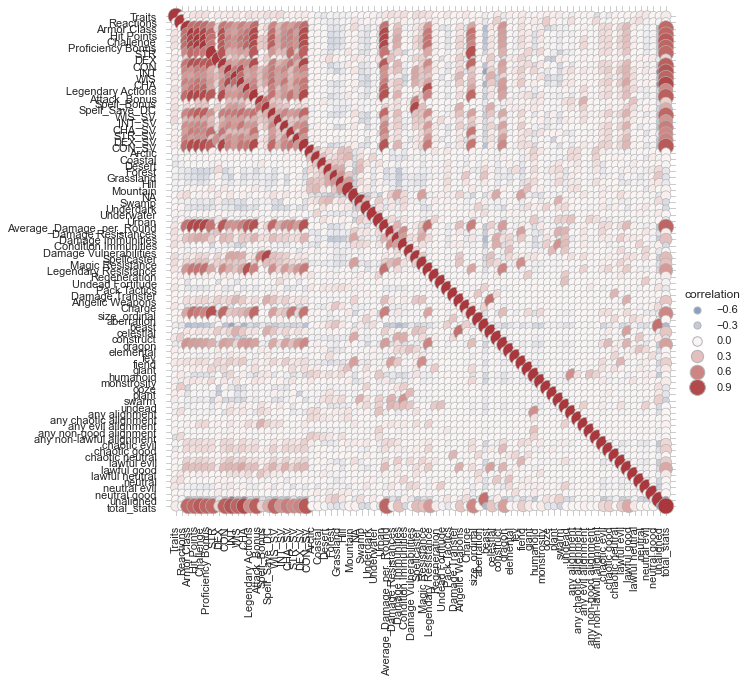

In [33]:
sns.set_theme(style="whitegrid")


used_columns = monster_df_wordless.columns
                                    
df = monster_df_wordless.loc[:, used_columns]

# Compute a correlation matrix and convert to long-form
corr_mat = df.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [34]:
# Create a stat only database for comparisons
monster_df_numeric = monster_df[['Hit Points', 'Armor Class','Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Attack_Bonus', 'Challenge']]

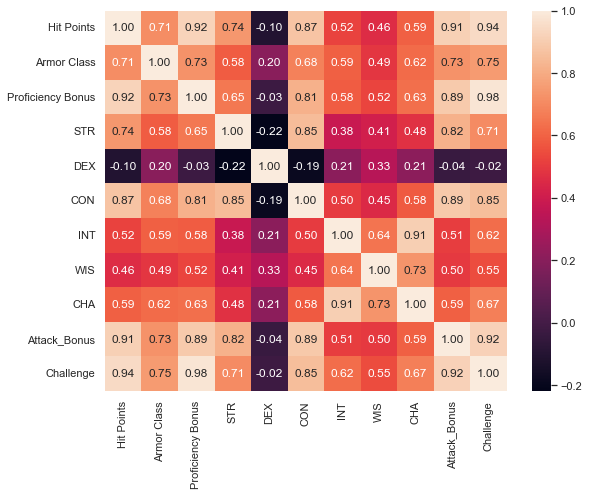

In [35]:
#Smaller Heatmap of stats only
fig = plt.figure(figsize = (9,7));
sns.heatmap(monster_df_numeric.corr(), annot = True, fmt = '.2f');

Today i learned that in monsters, dexterity has no correlation to any other numeric stat including challenge rating. The closest thing is wisdom...so sometimes things that are wise are also dexterous. 

We will not use Proficiency Bonus moving forward as it is really just linked to CR, so it won't tell us much. Basically, every CR that goes up, the proficiency goes up as well. Just like players levels.

#### Pair grids are great for comparing the distributions of LOTS of items at once

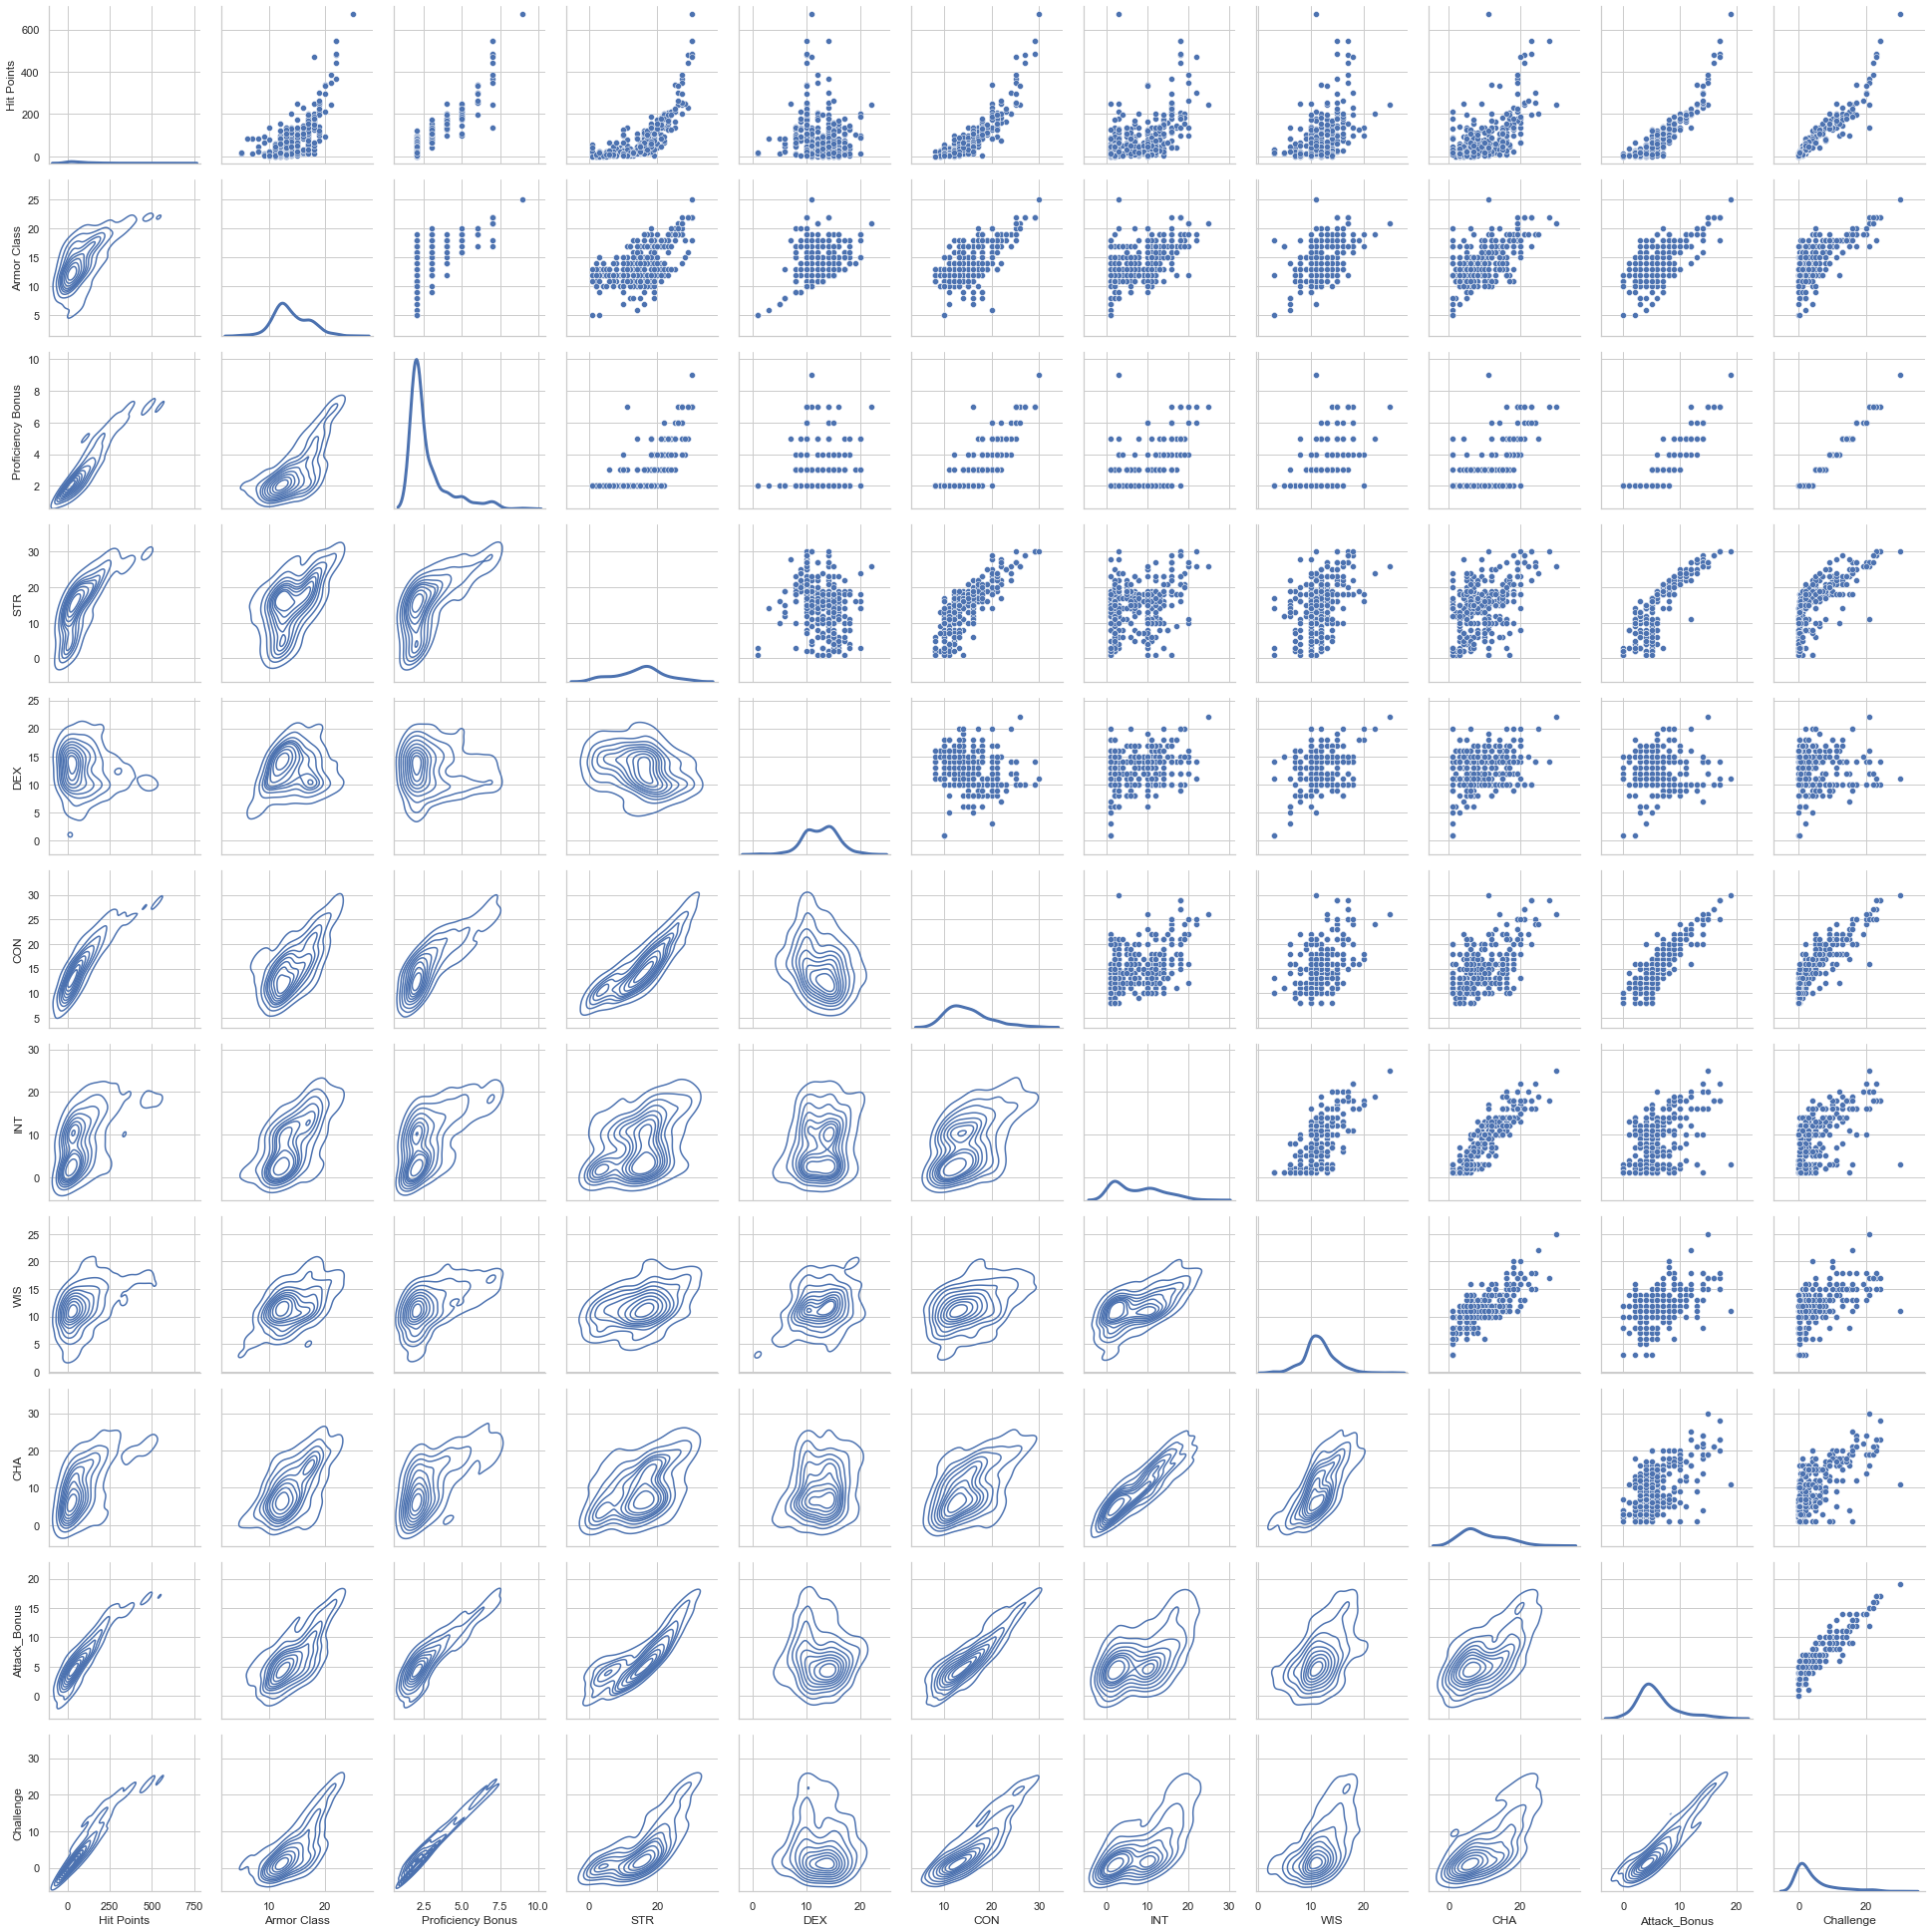

In [36]:
compare_plots = sns.PairGrid(monster_df_numeric)
compare_plots.map_upper(sns.scatterplot)
compare_plots.map_lower(sns.kdeplot)
compare_plots.map_diag(sns.kdeplot,lw=3,legend=False)

This pairgrid provides us a means to understand correlation and distribution of our stats as they compare with each other. We can see very highly correlated items like Challenge Rating and Attack Bonus. We can also see very low correlations like Dexerity and Challenge rating. Very interested to see that Constitution is the most highly correlated main stat against Challenege Rating. Hit Points and Attack Bonus are as well, which makes sense. The joint distribution graphs also provide us with a means to identify the modes of these stats: the center of our joint distributions. Interesting to find that Intellect has two modes when plotted against challenge rating, one that is almost zero, another that is closer to 10. This suggests a lot of our monsters have below average intelligence.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


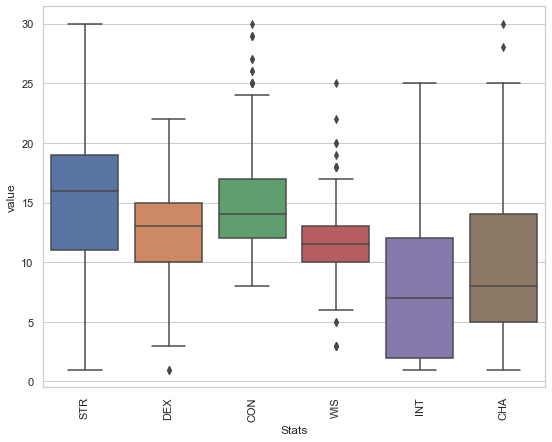

In [37]:
stats_df = pd.melt(monster_df, value_vars= [ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_df.columns=["Stats","value"]


fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(stats_df["Stats"], stats_df["value"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

There is clear variability between the quartiles and averages of each of our stats. This means our monster stat blocks are highly variable as well, when considering stats. Strength and Constitution do appear very close, so we will do a pairwise analysis to see if they are not statistically different. 

In [38]:
# Anova of Stats
model = ols('value ~ C(Stats)', data=stats_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df           F         PR(>F)
C(Stats)  14931.113027     5.0  121.333093  6.702596e-113
Residual  51241.712644  2082.0         NaN            NaN

In [39]:
# Pairwise analysis of stats
res = stat()
res.tukey_hsd(df=stats_df, res_var="value",xfac_var="Stats",anova_model="value~C(Stats)")

'''Strength and Constitution are the only two no significantly different from one another, which definitely tracks. Dex and WIS coming in close again. SO strange'''
res.tukey_summary

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1 group2      Diff     Lower     Upper    q-value   p-value
0     STR    DEX  2.244253  1.171506  3.317000   8.438980  0.001000
1     STR    CON  0.040230 -1.032517  1.112977   0.151275  0.900000
2     STR    WIS  3.344828  2.272081  4.417575  12.577430  0.001000
3     STR    INT  7.267241  6.194494  8.339988  27.326735  0.001000
4     STR    CHA  5.402299  4.329552  6.475046  20.314062  0.001000
5     DEX    CON  2.284483  1.211736  3.357230   8.590255  0.001000
6     DEX    WIS  1.100575  0.027828  2.173322   4.138450  0.040513
7     DEX    INT  5.022989  3.950242  6.095735  18.887755  0.001000
8     DEX    CHA  3.158046  2.085299  4.230793  11.875082  0.001000
9     CON    WIS  3.385057  2.312311  4.457804  12.728705  0.001000
10    CON    INT  7.307471  6.234724  8.380218  27.478010  0.001000
11    CON    CHA  5.442529  4.369782  6.515276  20.465337  0.001000
12    WIS    INT  3.922414  2.849667  4.995161  14.749306  0.001000
13    WIS    CHA  2.057471  0.984724  3.130218   7.736632  0.001000
14    INT    CHA  1.864943  0.792196  2.937689   7.012673  0.001000

As we can see STR vs CON has a p-value of 0.9, meaning they are not statistically different. This makes sense. If a monster is tough, it is also strong. If it is brittle, it is also weak. 

In [40]:
#Save modeling dataframe
monster_df_wordless.to_csv('../data/processed/Monster_modeling_df.csv')

## Question 3: How do the monster’s non-stat-oriented categories (type, environment, size, alignment) impact its stats?

In [41]:
monster_df.columns

Index(['Monster Name', 'Size', 'Type', 'Alignment', 'Traits', 'Reactions',
       'Armor Class', 'Hit Points', 'Speed', 'Challenge', 'Proficiency Bonus',
       'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Actions',
       'Legendary Actions', 'Environment', 'Attack_Bonus', 'Spell_Bonus',
       'Spell_Save_DC', 'WIS_SV', 'INT_SV', 'CHA_SV', 'STR_SV', 'DEX_SV',
       'CON_SV', 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill',
       'Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban',
       'Average_Damage_per_Round', 'Damage Resistances', 'Damage Immunities',
       'Condition Immunities', 'Damage Vulnerabilities', 'Spellcaster',
       'Magic Resistance', 'Legendary Resistance', 'Regeneration',
       'Undead Fortitude', 'Pack Tactics', 'Damage Transfer',
       'Angelic Weapons', 'Charge'],
      dtype='object')

### Distribution of Inputs for Dataset

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


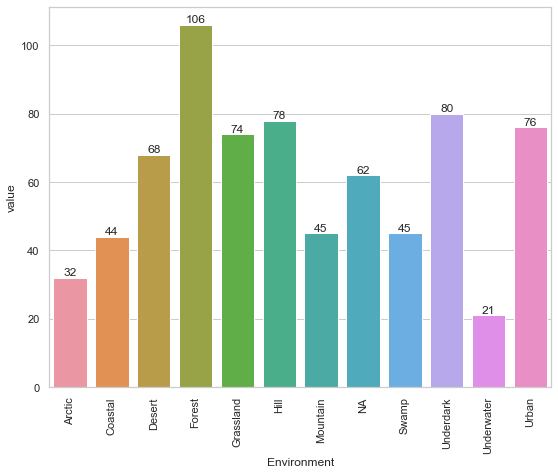

In [42]:
# Create a dataframe for environmental feature and count them
environment_df = pd.melt(monster_df, value_vars=[ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environment_df.columns = ['Environment', 'value']
environment_df  = environment_df.groupby('Environment').sum().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(environment_df["Environment"], environment_df['value'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

We have a good amount of monsters from all environments, underwater at the lowest.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


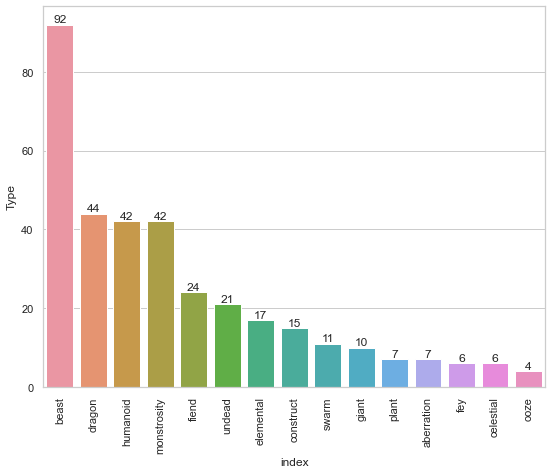

In [43]:
type_df = monster_df["Type"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(type_df["index"], type_df['Type'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

Beasts are the most common monsters in the dataset. This may have some interesting impacts on our model.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


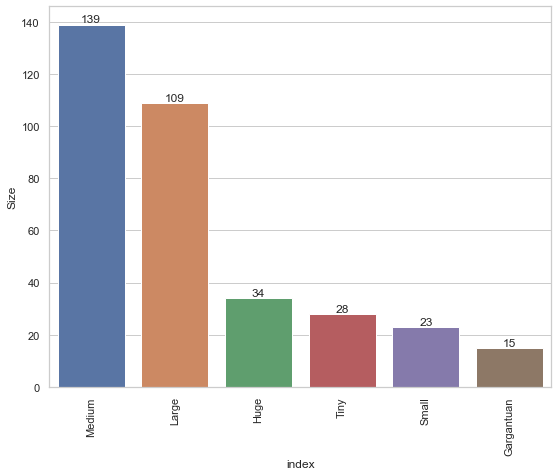

In [44]:
size_df = monster_df["Size"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(size_df["index"], size_df['Size'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

Since medium is the average size for most humanoids, it makes sense that this would be the highest count of the sizes

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


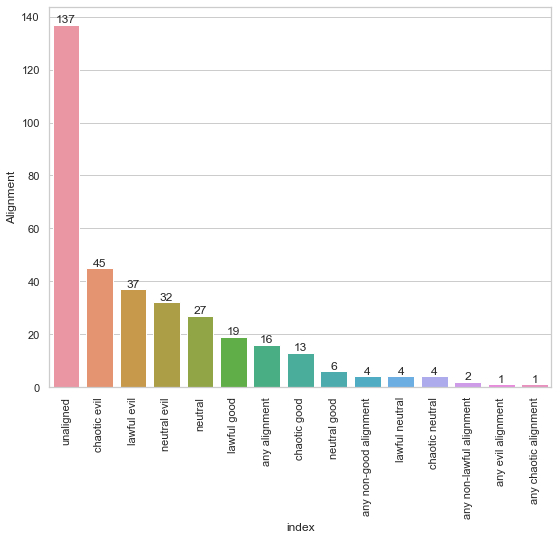

In [45]:
alignment_df = monster_df["Alignment"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(alignment_df["index"], alignment_df['Alignment'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

The fact that so many of our monsters are unaligned is not great. This may have an interesting impact on our model and something we need to be aware of moving forward.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


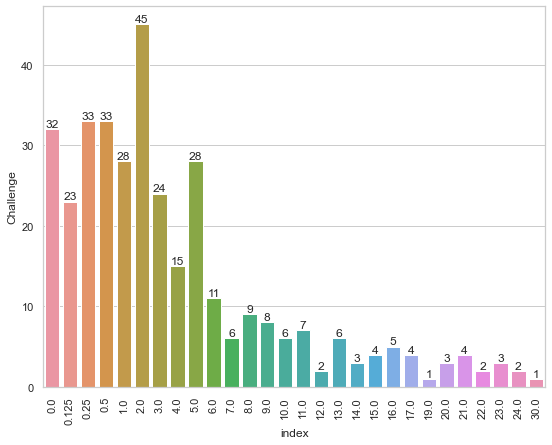

In [46]:
challenge_df = monster_df["Challenge"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(challenge_df["index"], challenge_df['Challenge'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

Just like we saw in our distributions, most of our monsters are lower levels. This makes sense, the world can't have a surplus of universe destroying monsters.

### Input Categories vs. Stats How do they Compare?

#### Monster Type

In [47]:
#Stats dataframe
stats_box_df = pd.melt(monster_df, id_vars=['Type'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_box_df.columns = ['Type','Stats', 'value']

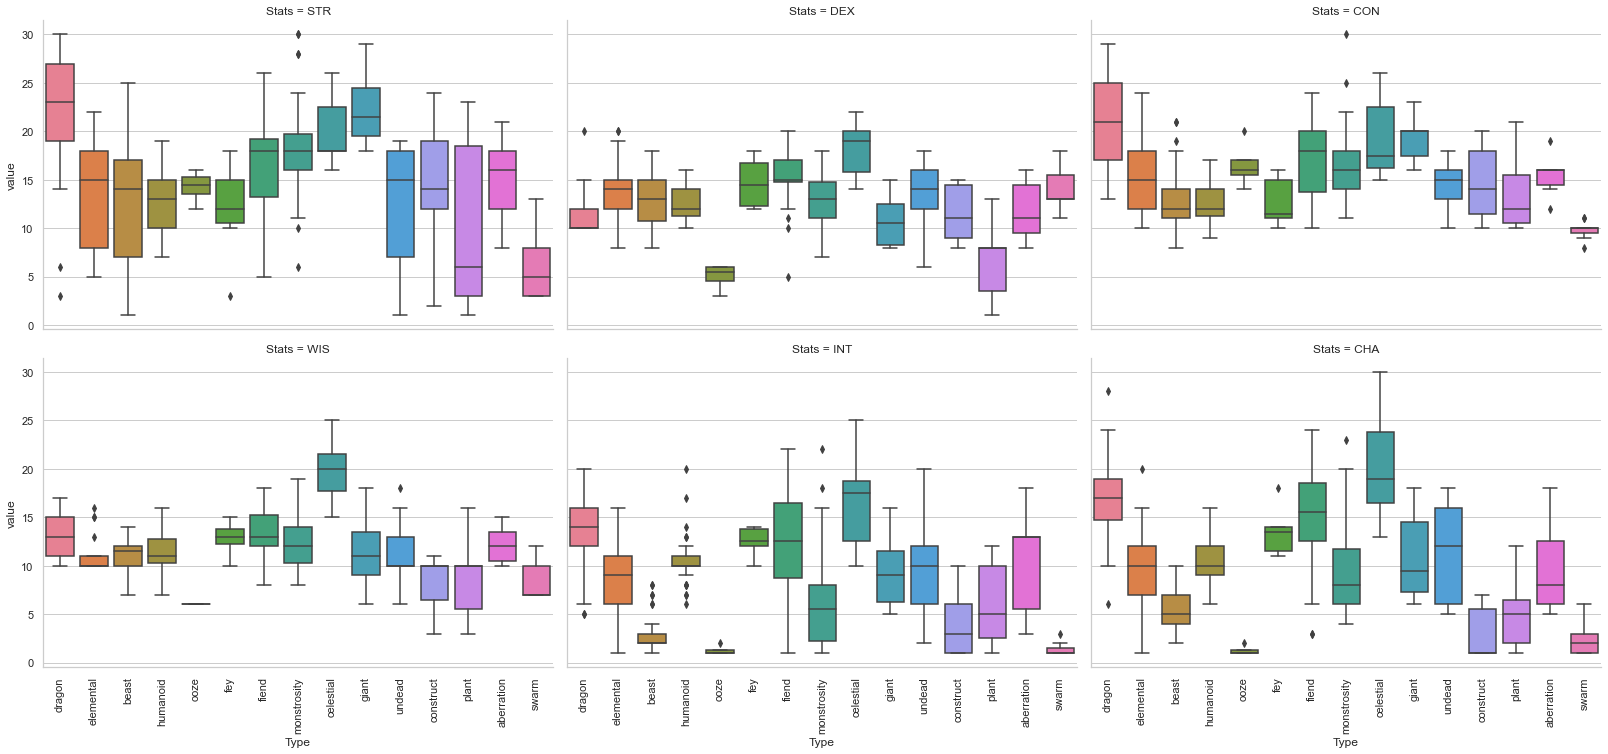

In [48]:
g = sns.FacetGrid(stats_box_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Type", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


We see high variability when comparing the monster types against the main stats. This will be a great addition to our inputs. Monstrosities have a few outliers, one of which is probably the tarrasque. 

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


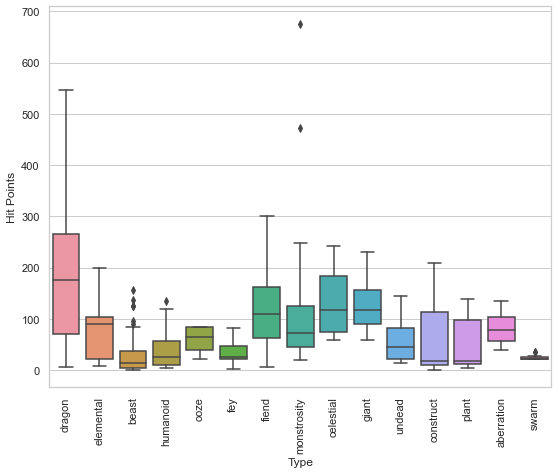

In [49]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Same thing here, monstrosity outliers for hitpoints. Dragons have a huge range, this is because they start as baby wrymlings and end up as all powerful ancient dragons.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


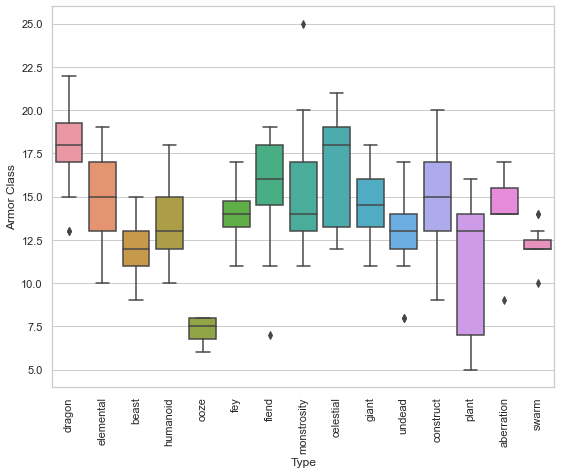

In [50]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
# Poor ooze

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


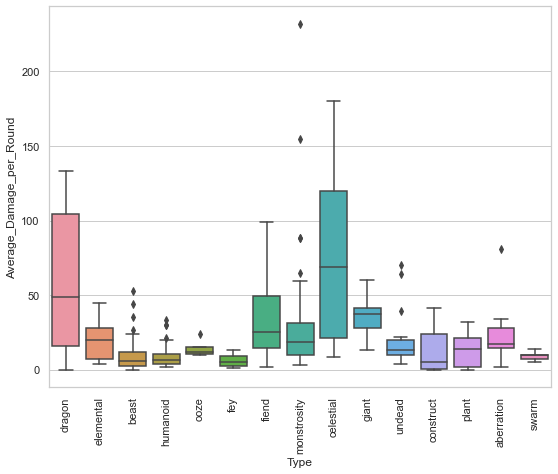

In [51]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Average_Damage_per_Round"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
# Poor ooze

The consistent outliers for monstrosity, really has me understanding how powerful the tarrasque is. Additionally, there is huge variability in the celestial type. Interesting to note that it has the highest damage output. This is probably the Solar monster.`

In [52]:
#saving_throw dataframe
type_saving_throw_df = pd.melt(monster_df, id_vars=['Type'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
type_saving_throw_df.columns = ['Type','Stats', 'value']

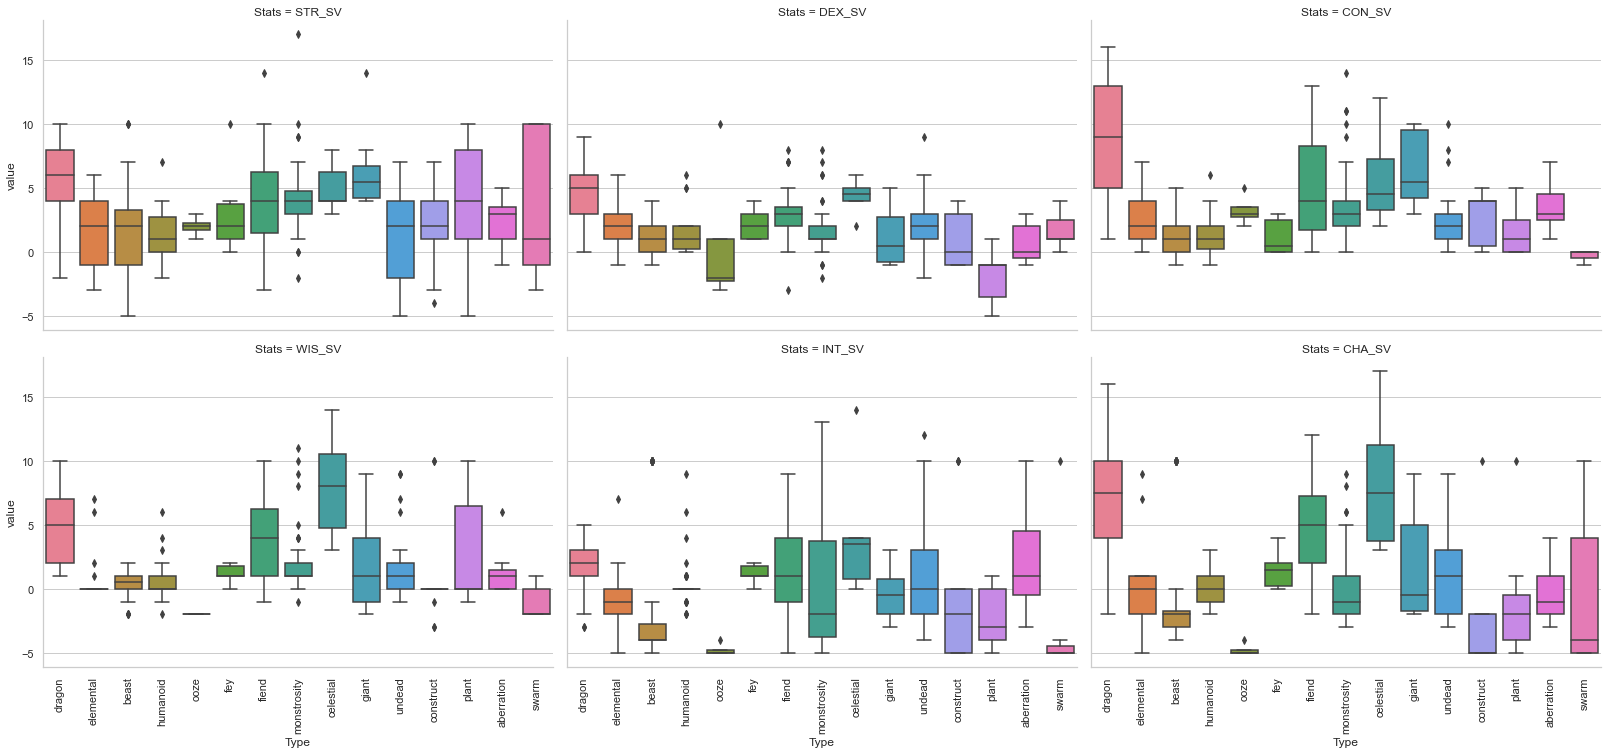

In [53]:
g = sns.FacetGrid(type_saving_throw_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Type", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


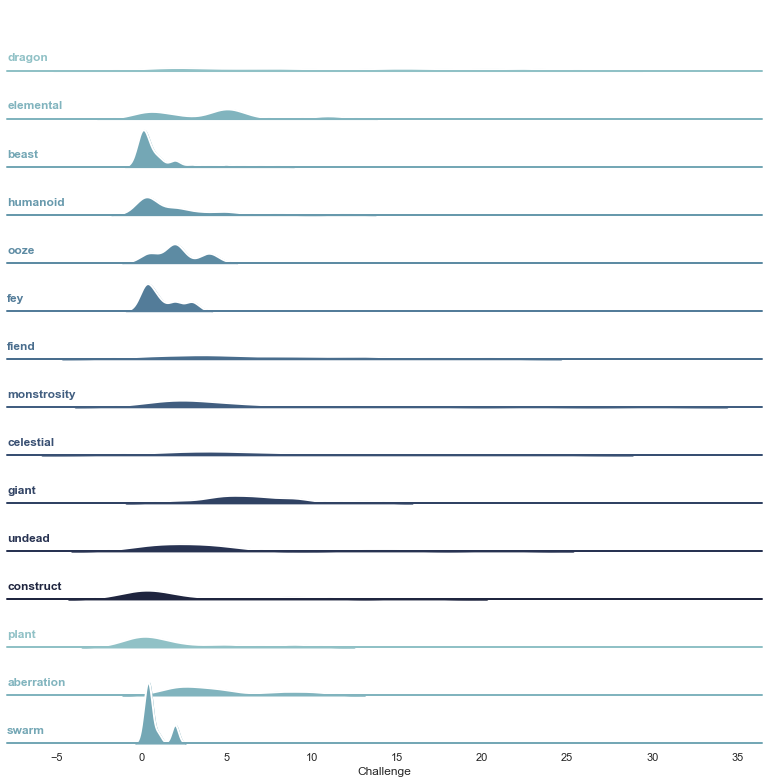

In [54]:
'''
This section was adapted from https://seaborn.pydata.org/examples/kde_ridgeplot.html
'''
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(monster_df, row="Type", hue="Type", aspect=15, height=.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

It appears we have variability when it comes to monster types and challenge rating. This will have an impact on the average stats for each monster unfortunately. 

#### Environment

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


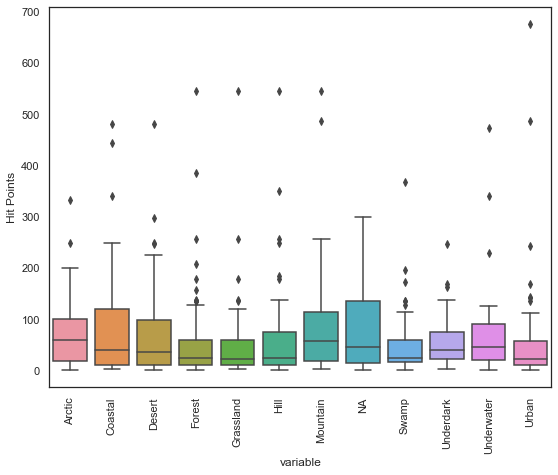

In [55]:
environment_HP_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Hit Points')

# Filter out 0 environment values caused by binary encoding
environment_HP_df =environment_HP_df.loc[environment_HP_df["value"] == 1]

fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(environment_HP_df["variable"], environment_HP_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

There doesn't appear to be much variability in environment vs. hitpoints. Quite a few outliers, which is understandable considering our tight quartile ranges.

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


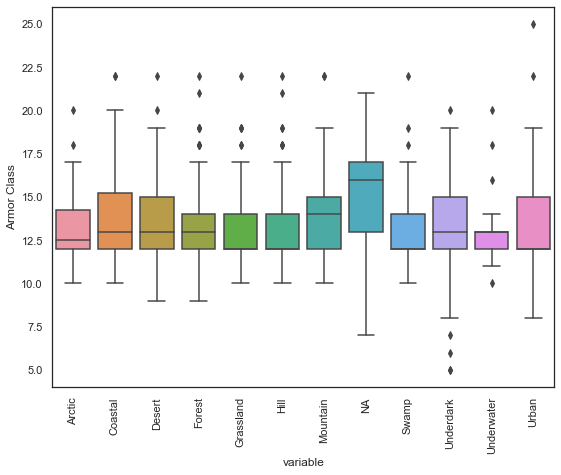

In [56]:
environment_armor_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Armor Class')

environment_armor_df =environment_armor_df.loc[environment_armor_df["value"] == 1]

fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(environment_armor_df["variable"], environment_armor_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Again, low variability here. the Environmental Input may not have a large impact on our model

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


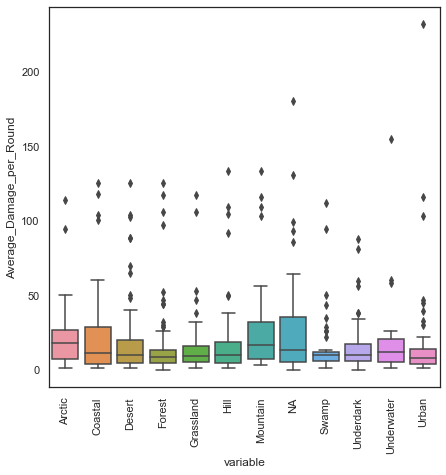

In [57]:
environment_damge_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Average_Damage_per_Round')

environment_damge_df =environment_damge_df.loc[environment_damge_df["value"] == 1]

fig = plt.figure(figsize = (7,7));
ax = sns.boxplot(environment_damge_df["variable"], environment_damge_df["Average_Damage_per_Round"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Low variablity, small quartiles, large number of outliers. Same conclusions as above

In [58]:
# Melt down Environments into a single columns with all stats
environment_stats_melt_df  = pd.melt(monster_df, id_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'], value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environment_stats_melt_df.columns = ['STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA','Environment', 'value']
# Filter out the 0 value environments that occur due to binary encoding
environment_stats_melt_df=environment_stats_melt_df[environment_stats_melt_df['value']== 1]

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


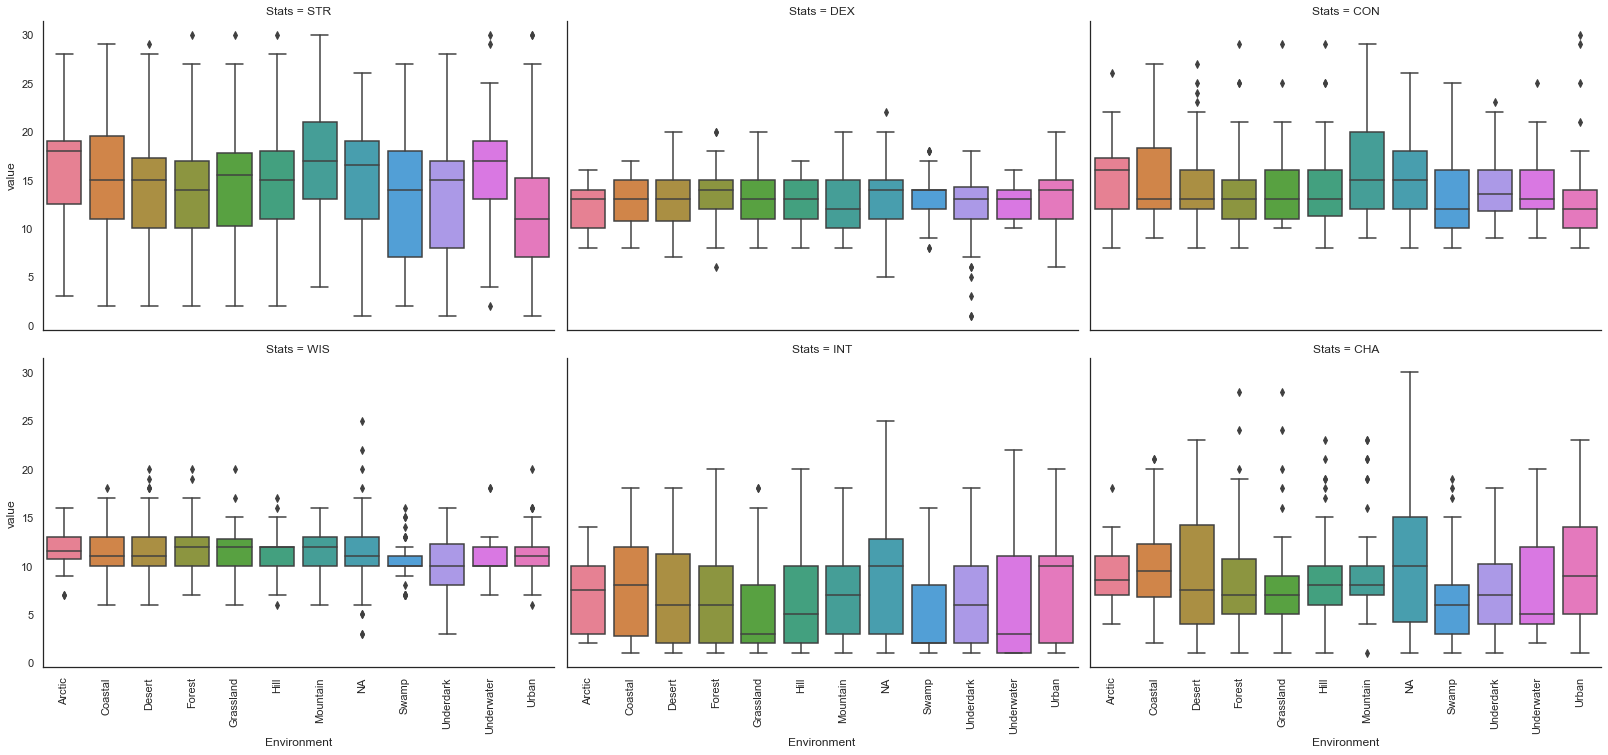

In [59]:
# Melt down stats into a pivot long format for Facet Graph
stats_environment_df = pd.melt(environment_stats_melt_df, id_vars=['Environment'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_environment_df.columns = ['Environment','Stats', 'value']

g = sns.FacetGrid(stats_environment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Environment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

These graphs all look almost identical. It appears all thes tats are similar for our monster environments.

In [60]:
# Melt down Environments into a single columns with all stats
environemt_saving_throw_df  = pd.melt(monster_df, id_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'], value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environemt_saving_throw_df.columns = ['STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV', 'Environment', 'value']
# Filter out the 0 value environments that occur due to binary encoding
environemt_saving_throw_df=environemt_saving_throw_df[environemt_saving_throw_df['value']== 1]

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


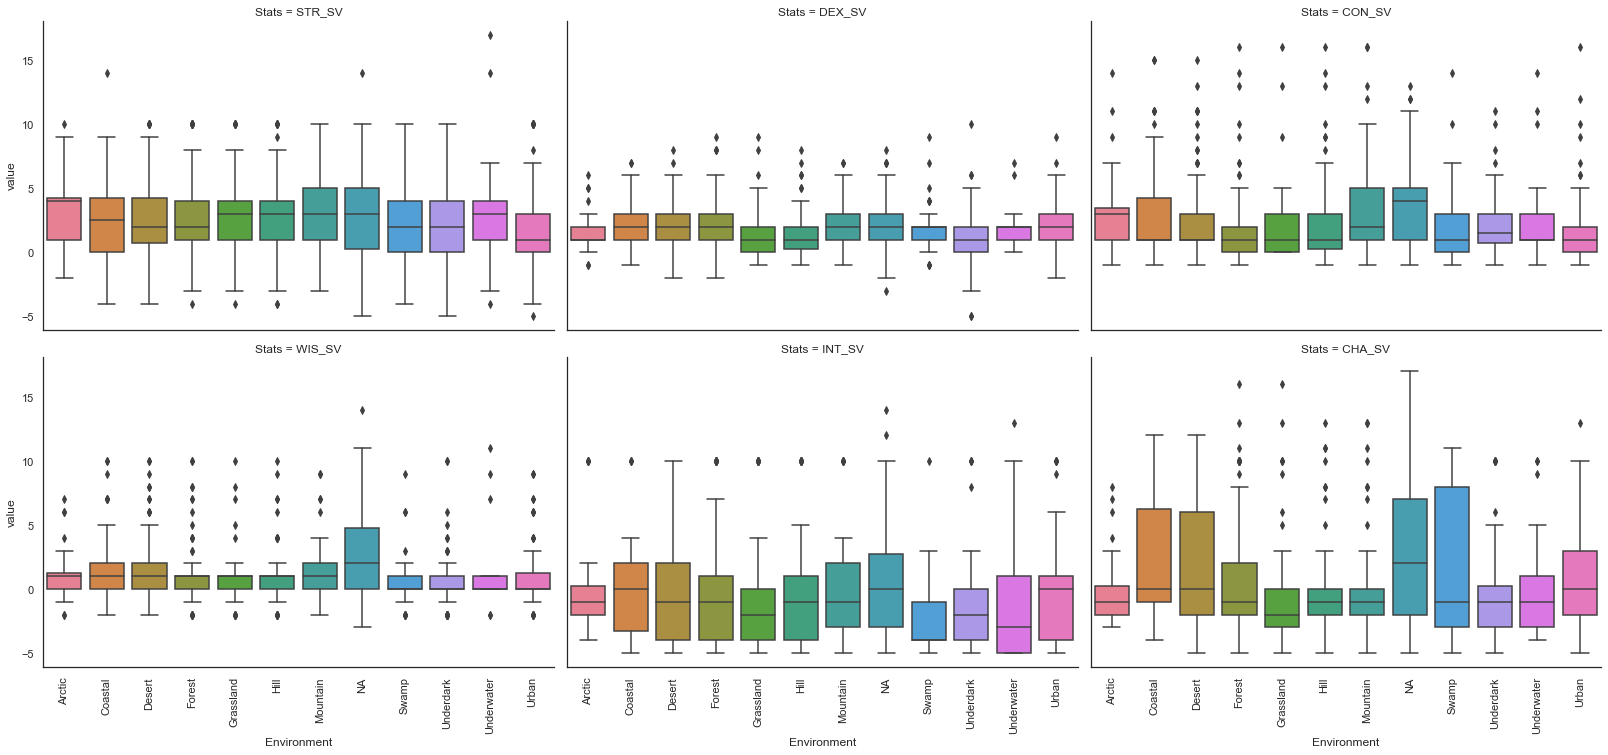

In [61]:
# Melt down stats into a pivot long format for Facet Graph
saving_throw_environment_df = pd.melt(environemt_saving_throw_df, id_vars=['Environment'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_environment_df.columns = ['Environment','Stats', 'value']

g = sns.FacetGrid(saving_throw_environment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Environment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [ ]:
#Create challenge rating and environmental dataframe
challenge_enviro = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = ['Challenge'])
challenge_enviro =challenge_enviro.loc[challenge_enviro["value"] == 1]
challenge_enviro.drop('value',axis=1,inplace=True)
challenge_enviro

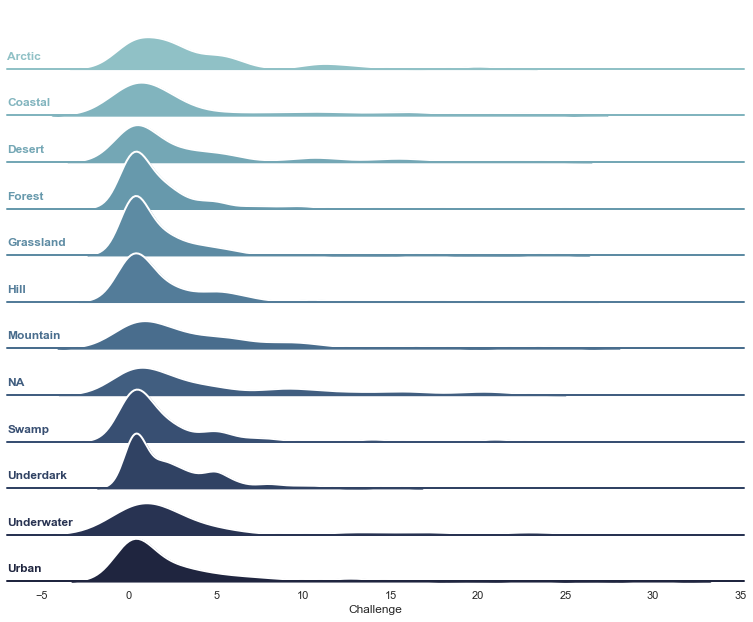

In [63]:
'''
This section  was adapted from https://seaborn.pydata.org/examples/kde_ridgeplot.html
'''
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(challenge_enviro, row="variable", hue="variable", aspect=15, height=.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)



We can see that the distribution here is very similiar for each environment against challenge rating. This might be why the stat blocks are so similar. 

#### Alignment

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


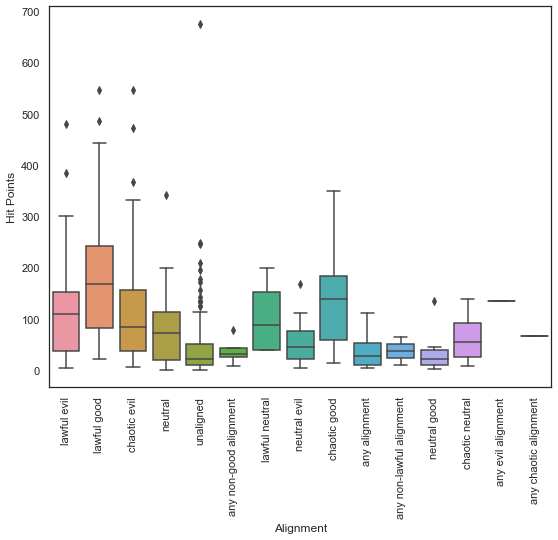

In [64]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Alignment"], monster_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Some variability here. Looks like good is actually stronger than evil generally speaking. unaligned most likely has the game breaking tarrasque. It would be interesting to combine these into good, evil or chaotic and lawful to do a further analysis at some point

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


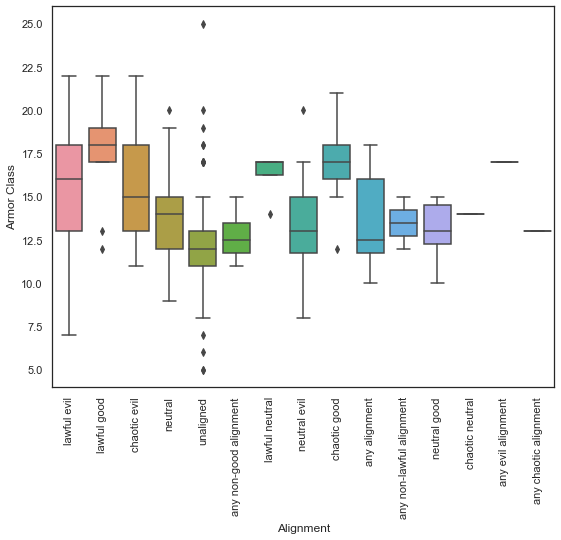

In [65]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Alignment"], monster_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Variability here as well. It looks like alignment will be another strong candidate for our inputs. Interesting to not the three final values don't appear to have large counts. This feature may benefit from consolidation.

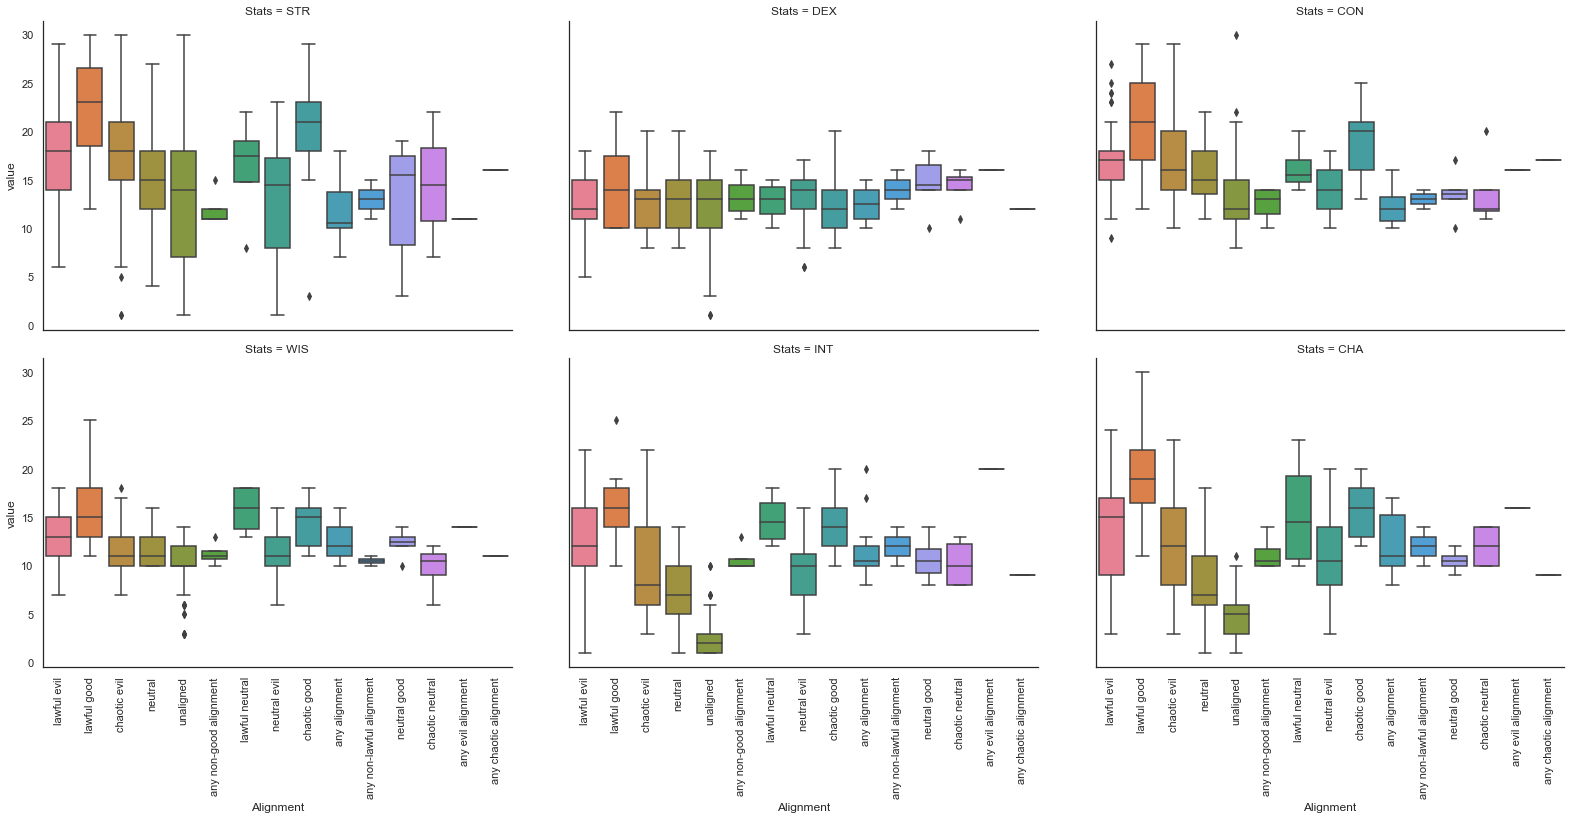

In [66]:
# Melt down stats into a pivot long format for Facet Graph
alignment_stats_df = pd.melt(monster_df, id_vars=['Alignment'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])

alignment_stats_df.columns = ['Alignment','Stats', 'value']

g = sns.FacetGrid(alignment_stats_df, col="Stats", col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Alignment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

There is a good spead of stats here among the alignments. Unaligned has very low intellect and charisma. I would think most beast types are unaligned, which translates to those stats. 

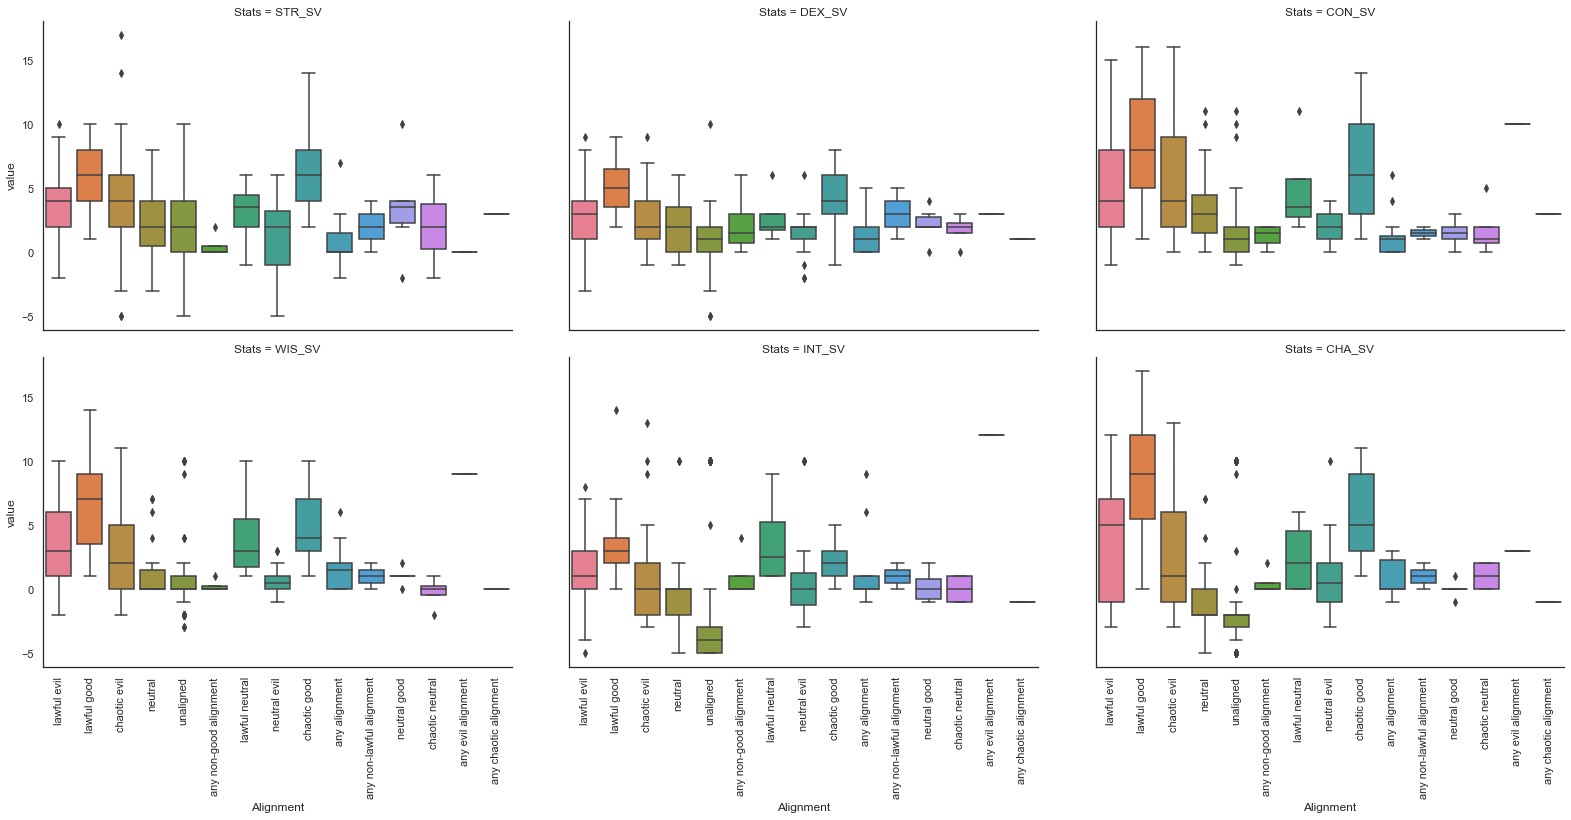

In [67]:
# Melt down saving throw into a pivot long format for Facet Graph
saving_throw_alignment_df = pd.melt(monster_df, id_vars=['Alignment'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_alignment_df.columns = ['Alignment','Stats', 'value']

g = sns.FacetGrid(saving_throw_alignment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Alignment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

#### Size

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


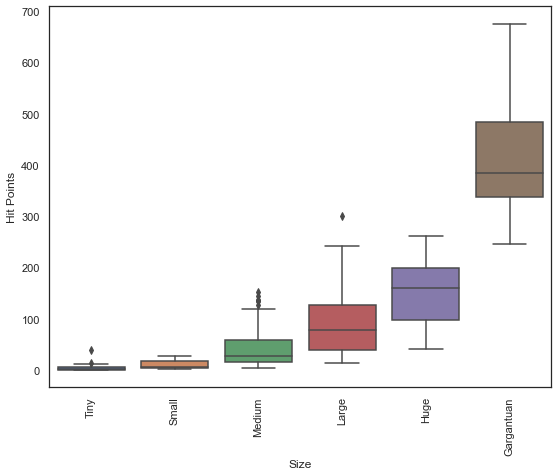

In [68]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Hit Points"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Size plays out very much as you would expect for hitpoints. The larger the monster, the more hitpoints it has

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


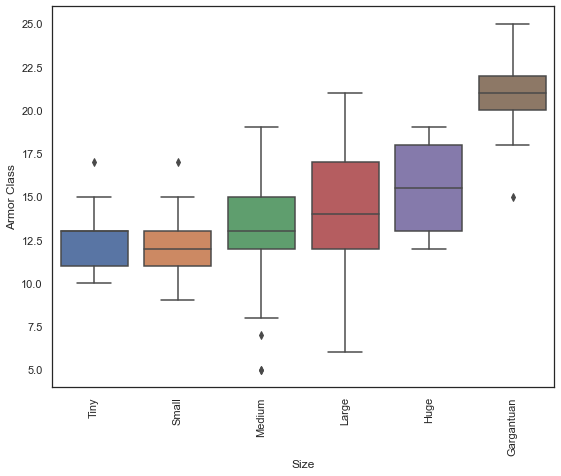

In [69]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Armor Class"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Same applies to armor. The larger, the tougher it is

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


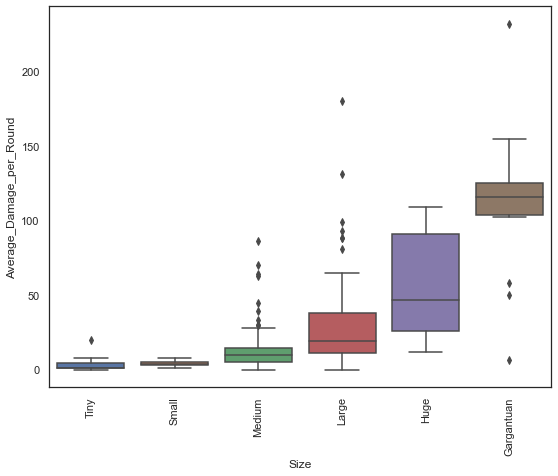

In [70]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Average_Damage_per_Round"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

I'm actually kind of surprised damage plays out this way however. It makes sense, but I would have guessed there were also very strong medium creatures. The quartile range is quite small for medium, so most of the monsters are weak in terms of damage.

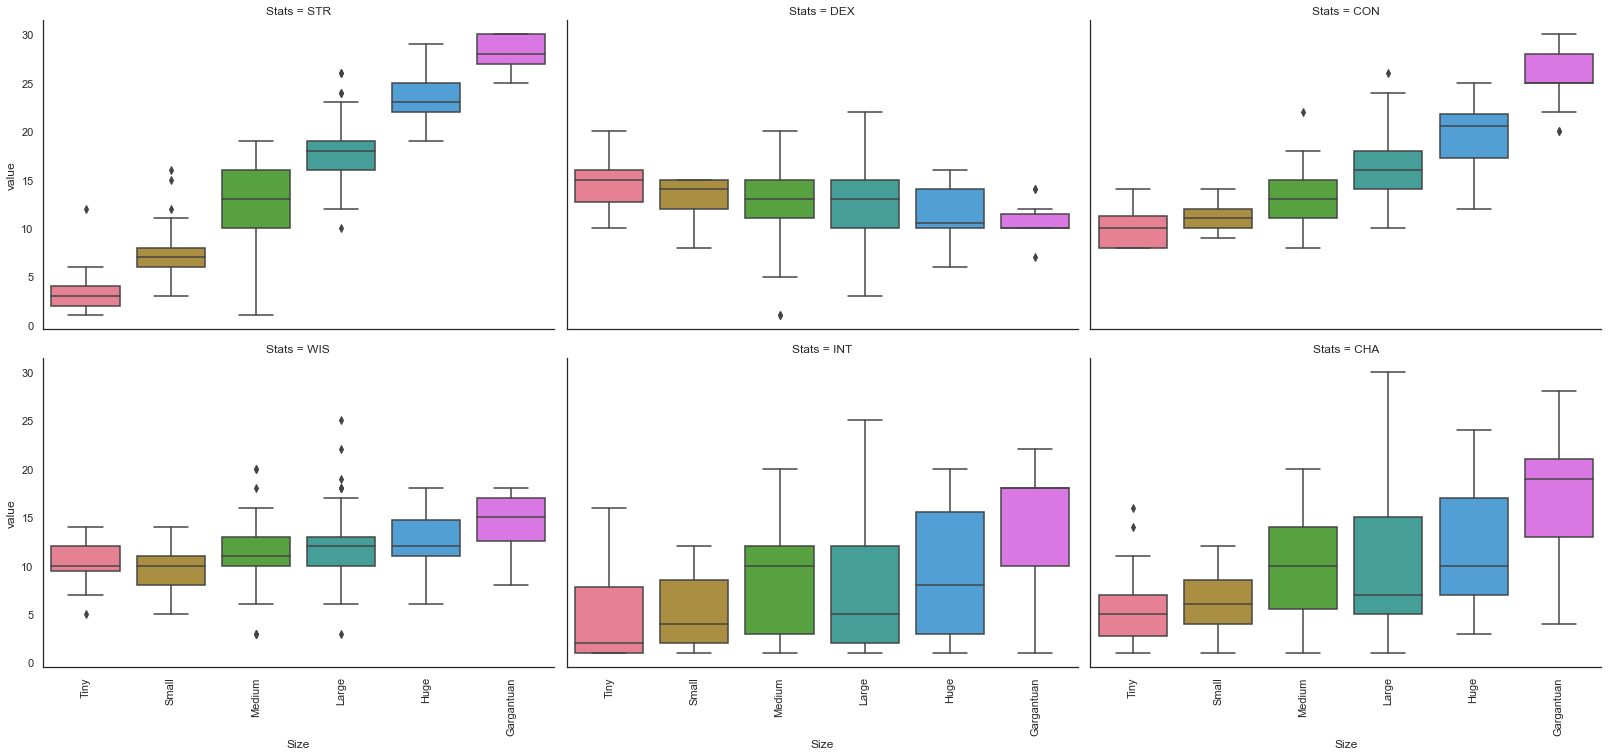

In [71]:
# Melt down stats into a pivot long format for Facet Graph
stats_size_df = pd.melt(monster_df, id_vars=['Size'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_size_df.columns = ['Size','Stats', 'value']

g = sns.FacetGrid(stats_size_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Size", palette = "husl", order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

Almost every single stat, except Dex, plays out as positively correlated with size. This is very interesting. I wouldn't expect size to have an impact on intelligence of charisma. It may also be that the larger they are, the higher there level is. So it just works out that their stats are higher. 

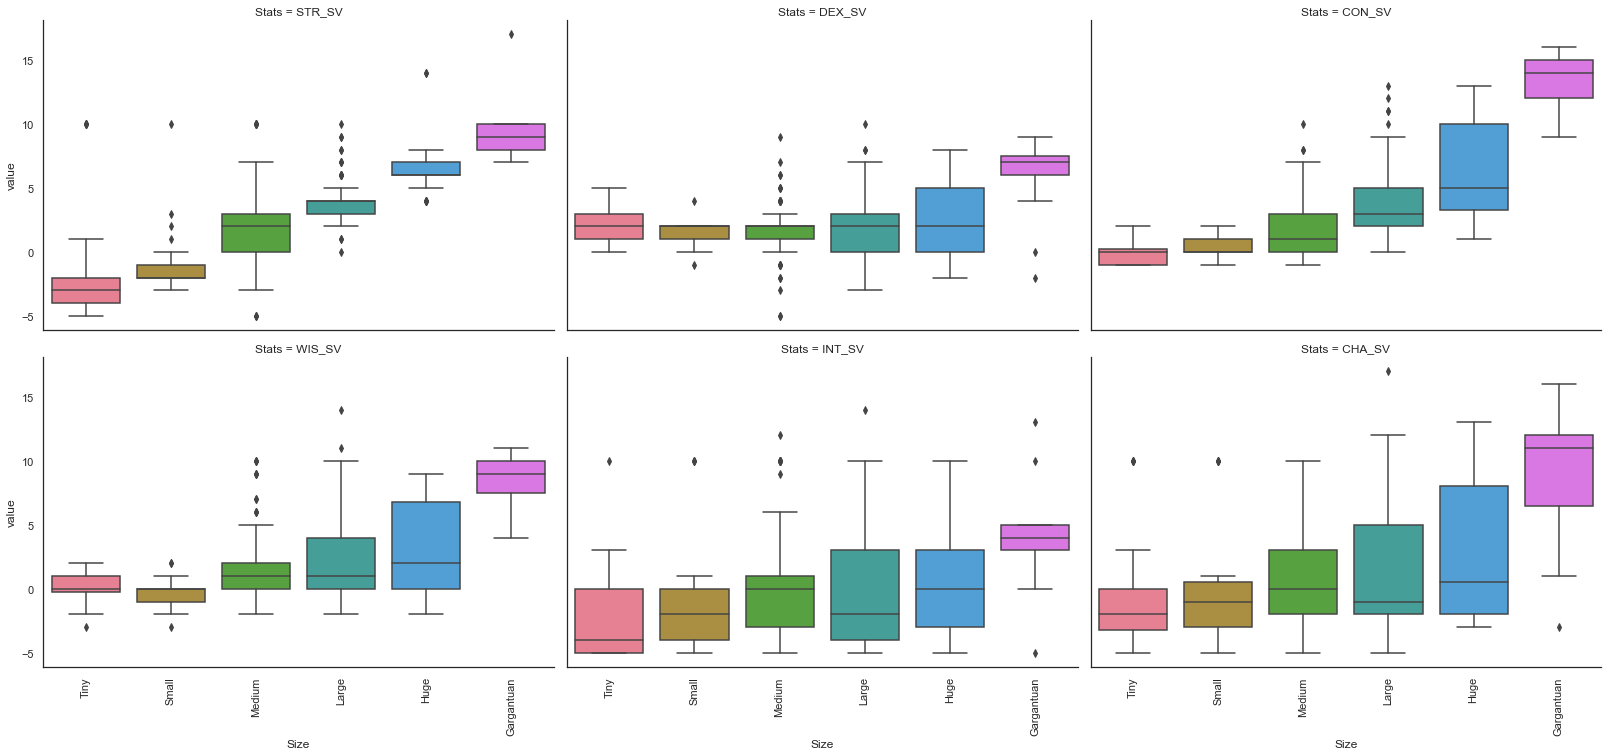

In [72]:
# Melt down saving throw into a pivot long format for Facet Graph
saving_throw_size_df = pd.melt(monster_df, id_vars=['Size'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_size_df.columns = ['Size','Stats', 'value']

g = sns.FacetGrid(saving_throw_size_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Size", palette = "husl", order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

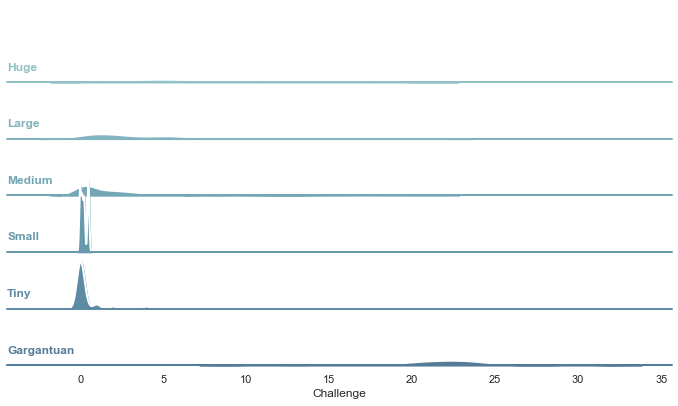

In [73]:
'''
This section was adapted from https://seaborn.pydata.org/examples/kde_ridgeplot.html
'''
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(monster_df, row="Size", hue="Size", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

The only thing to really interpret here is how far removed the gargantuans are in terms of challenege rating. Only 20-30. This tracks with our increase in stats above. 

### Looking at Environment, Monster Type, and CR stat blocks
I want to use these for the model we will make as our inputs, so we need a better idea of what they look like when related to our stats

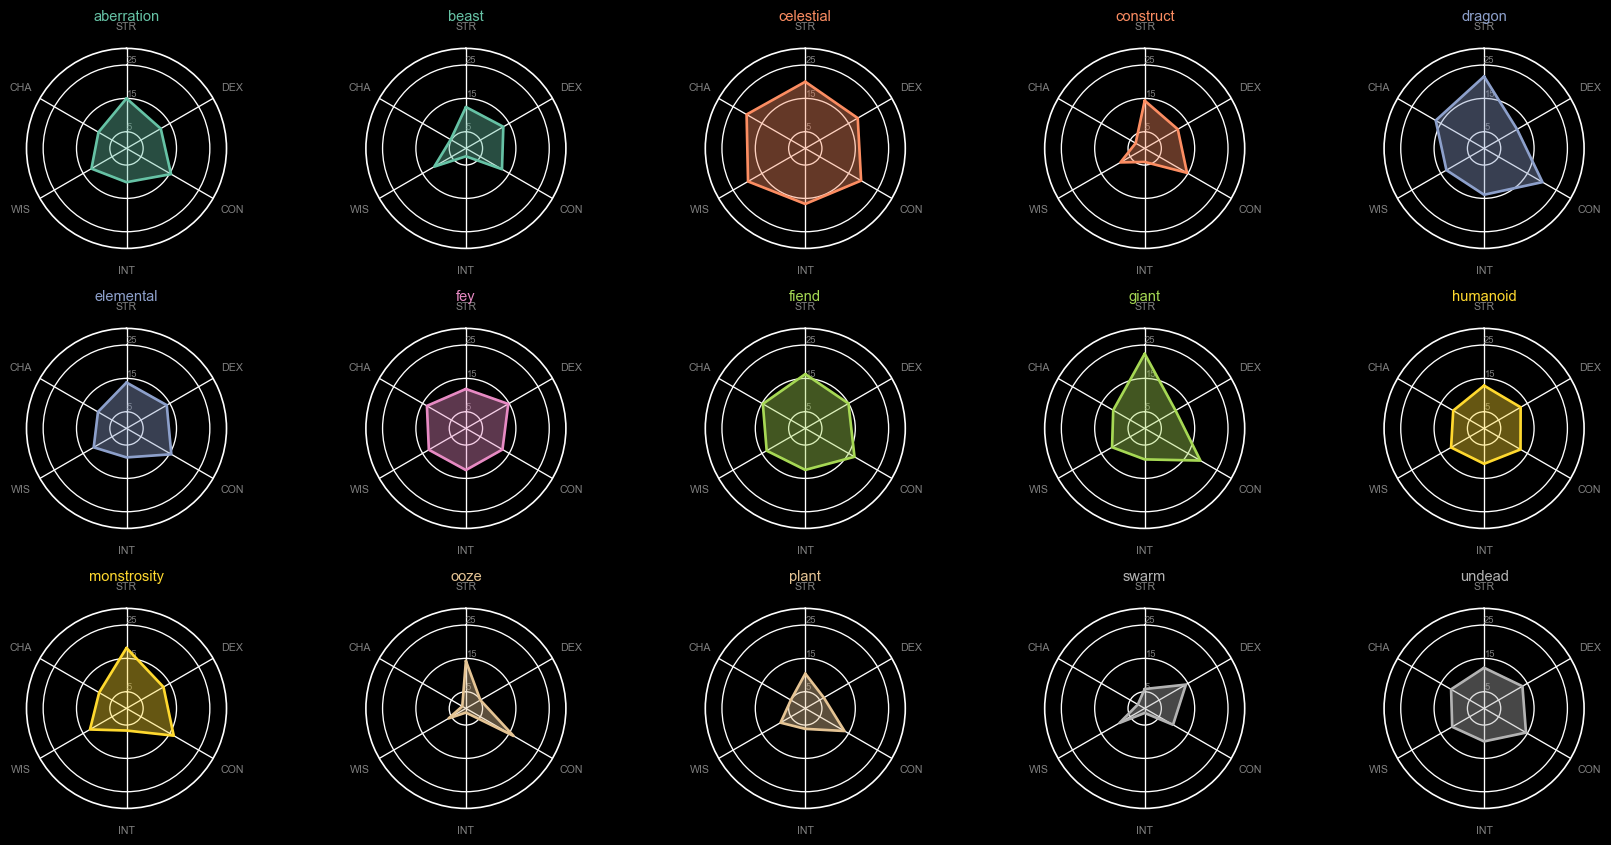

In [92]:
monster_stats = monster_df[['Type','STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_stats = monster_stats.groupby('Type').mean()
monster_stats = monster_stats.reset_index()

# Best way to see this is with as radar chart

def make_spider(df, group, row, title, color):
    '''
    This function takes a data frame, the feature you want to iterate over and each row of data that is also used from each grouped by category and creates a radar chart for each category. 
    
    inputs:
            df: dataframe with require inputs
            group: what feature you are using to iterate the radar charts
            row: row of data you are plotting (turns into position on subplot)
            title: title for the radar chart for each sub chart
            color: color for the radar chart for each sub chart
    outputs:
            radar plot based on inputs

    adapted from python-graph-gallery
    '''
    # Number of variables
    categories = list(df)[1:7]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(6, 5, row+1, polar = True, )
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, 
                        top = 0.9, wspace = 0.4, hspace = 0.4)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color = "grey", size = 8)
    plt.style.use("dark_background")
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([5,15,25], ["5", "15", "25"], color="grey", size = 7)
    plt.ylim(0,30)

    # Ind1
    values = df.loc[row].drop(labels = [group]).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, color = color, alpha = 0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi = 96
plt.figure(figsize = (2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_stats.index))

# Loop to plot
for row in range(0, len(monster_stats.index)):
    make_spider(df = monster_stats,  group = 'Type', 
                row = row, title = monster_stats['Type'][row], 
                color = my_palette(row))
    




These charts are great to understand how different each category is when comparing them against stats. The starkly different shapes show us that each monster type is different when it comes to stat makeup.

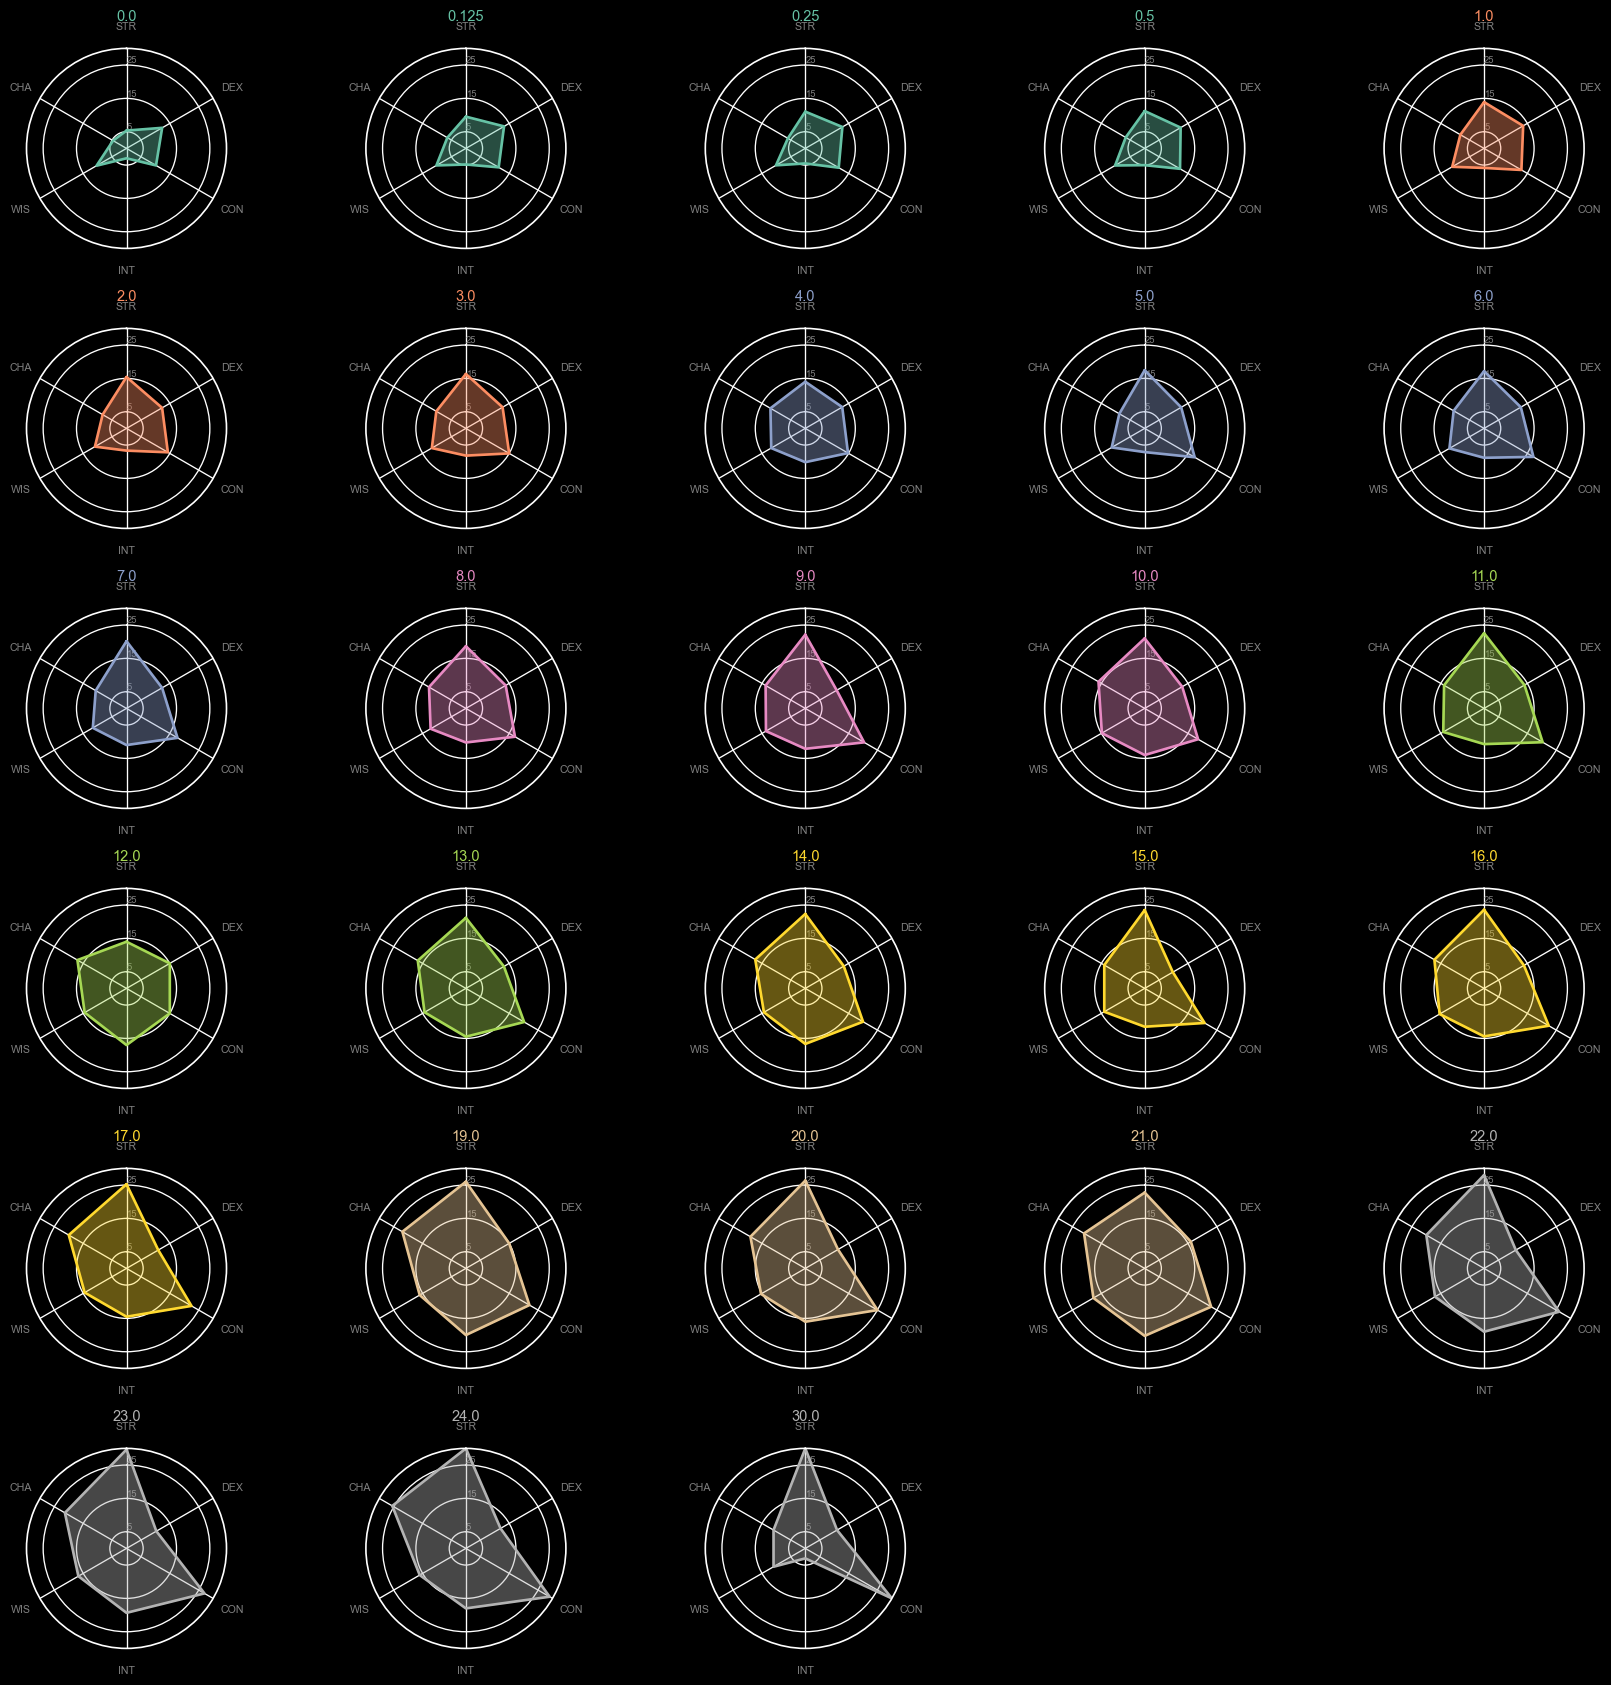

In [75]:
monster_challenge = monster_df[['Challenge', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_challenge = monster_challenge.groupby('Challenge').mean()
monster_challenge = monster_challenge.reset_index()

# initialize the figure
my_dpi = 96
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_challenge.index))

# Loop to plot
for row in range(0, len(monster_challenge.index)):
    make_spider(df = monster_challenge, group = 'Challenge', 
                row = row, title = monster_challenge['Challenge'][row], 
                color = my_palette(row))

We can see a general increase in stats numbers here as challenge rating increase. We can also see that there is a changing of shape as well. 2 CR and below all have similar shapes, however above 2 we see strength start to emerge. There is a definite relationship with challenege rating and monster stats. 

In [76]:
# Create an environment & Stats dataframe for radar charts
stats_enviro = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = ['STR','DEX','CON','INT','WIS','CHA'])
stats_enviro =stats_enviro.loc[stats_enviro["value"] == 1]
stats_enviro.drop('value',axis=1,inplace=True)
stats_enviro.columns = ['STR','DEX','CON','INT','WIS','CHA','Environment']
stats_enviro.insert(0,'Environment',stats_enviro.pop('Environment'))
stats_enviro = stats_enviro.groupby('Environment').mean()
stats_enviro = stats_enviro.reset_index()

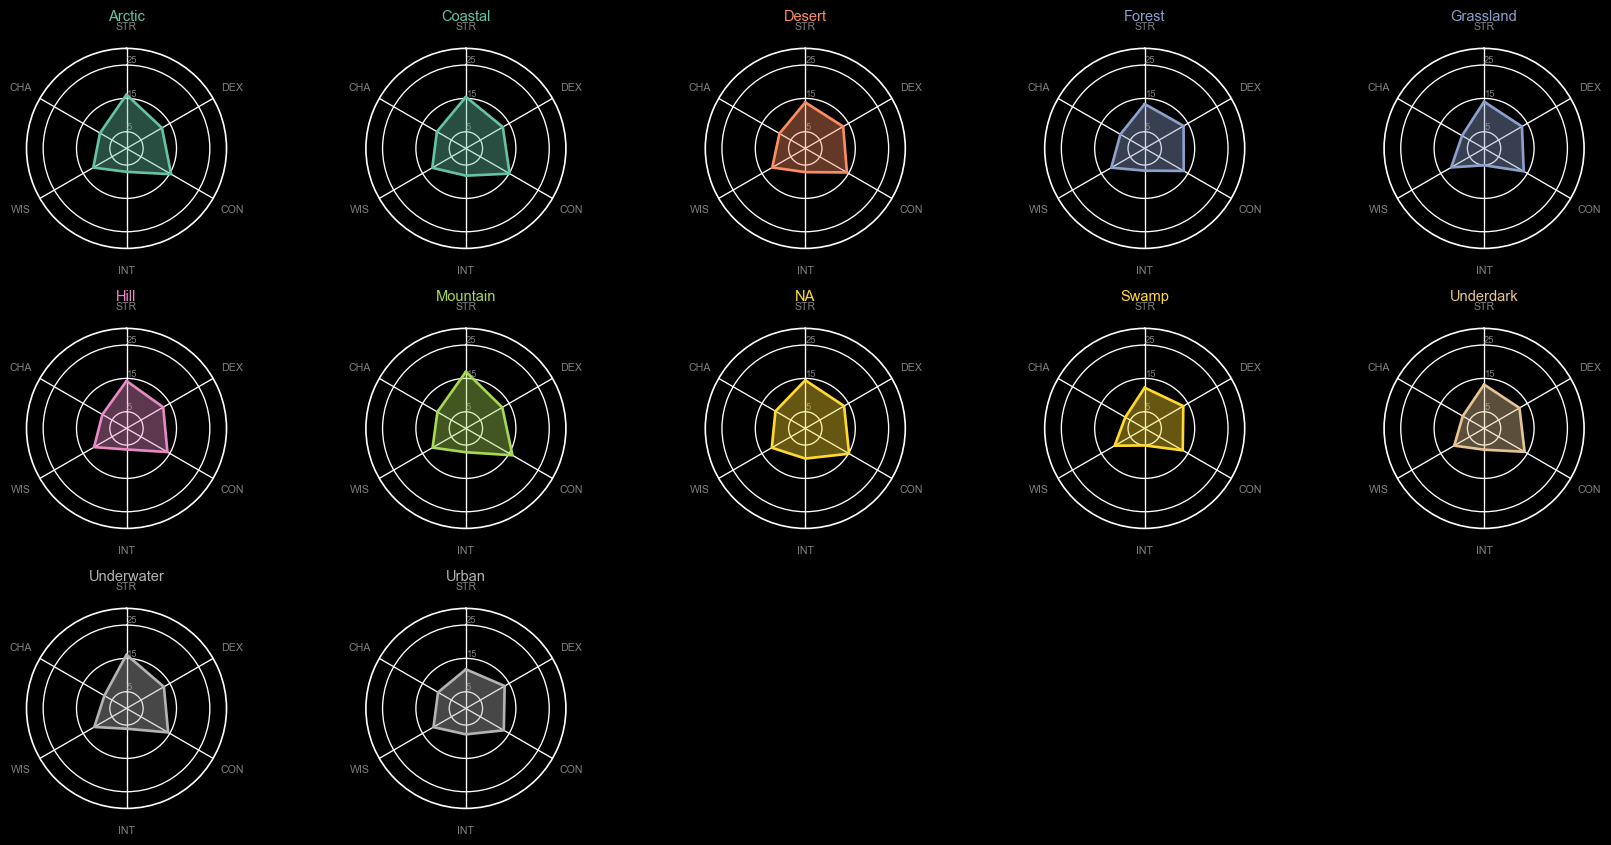

In [77]:
# Initialize the figure
my_dpi = 96
plt.figure(figsize = (2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(stats_enviro.index))

# Loop to plot
for row in range(0, len(stats_enviro.index)):
    make_spider(df = stats_enviro, group = 'Environment', 
                row = row, title = stats_enviro['Environment'][row], 
                color = my_palette(row))

In terms of environment, there actually appears to be two distinct shapes. One with a high strenth/consitution and another with a more well rounded, but lower intellect shape. The later may be impacted by the beast type.

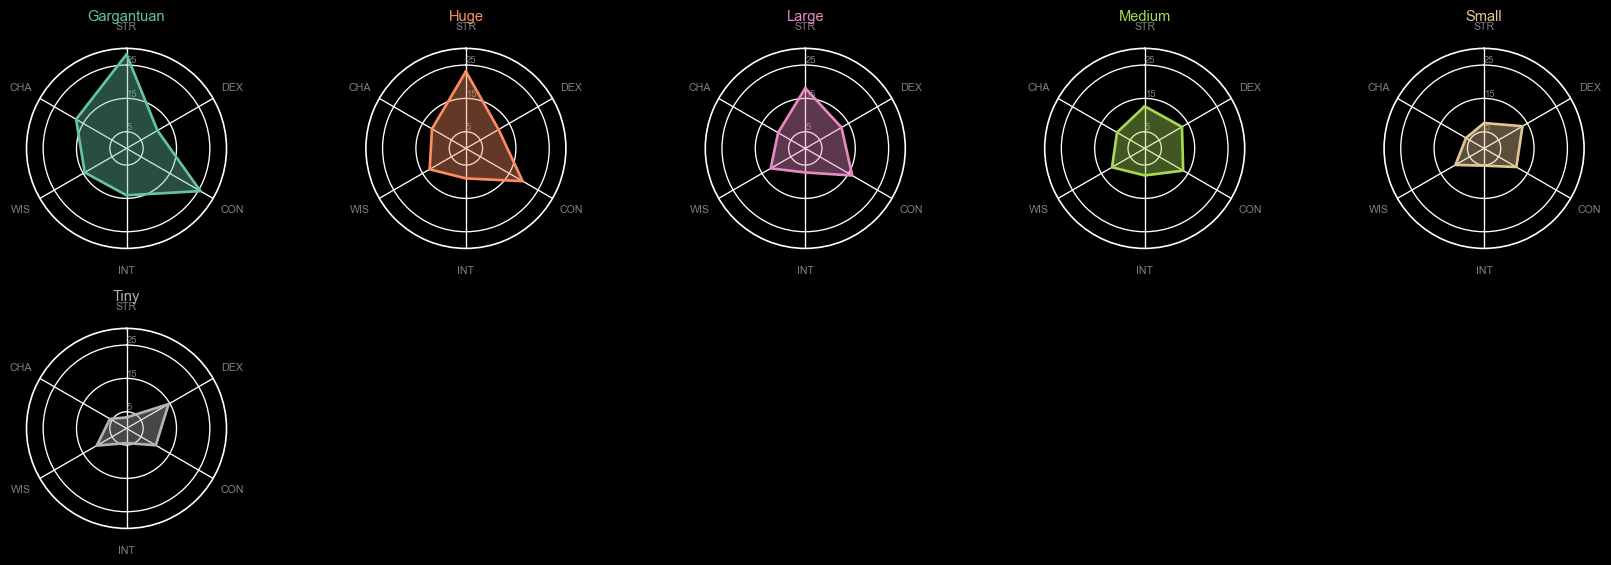

In [78]:
monster_Size = monster_df[['Size', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_Size = monster_Size.groupby('Size').mean()
monster_Size = monster_Size.reset_index()

# initialize the figure
my_dpi = 96
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_Size.index))

# Loop to plot
for row in range(0, len(monster_Size.index)):
    make_spider(df = monster_Size, group = 'Size', 
                row = row, title = monster_Size['Size'][row], 
                color = my_palette(row))

Size has a very clear increase in stat number from tiny to gargantuan, however the shapes are also different. Tiny apears focused on dexterity, while gargantuan is focused on constitution/strength.

## Bonus: WordClouds

In [79]:
monster_df.isna().sum()

Monster Name                0
Size                        0
Type                        0
Alignment                   0
Traits                      0
Reactions                   0
Armor Class                 0
Hit Points                  0
Speed                       0
Challenge                   0
Proficiency Bonus           0
STR                         0
DEX                         0
CON                         0
INT                         0
WIS                         0
CHA                         0
Actions                     0
Legendary Actions           0
Environment                 0
Attack_Bonus                0
Spell_Bonus                 0
Spell_Save_DC               0
WIS_SV                      0
INT_SV                      0
CHA_SV                      0
STR_SV                      0
DEX_SV                      0
CON_SV                      0
Arctic                      0
Coastal                     0
Desert                      0
Forest                      0
Grassland 

In [80]:
#Create a blob of text
action_text = " ".join(row for row in monster_df.Actions)

In [81]:
dnd_logo = np.array(Image.open("../reports/figures/dnd_logo.jpeg"))

# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['hit','ft',"NA'"])

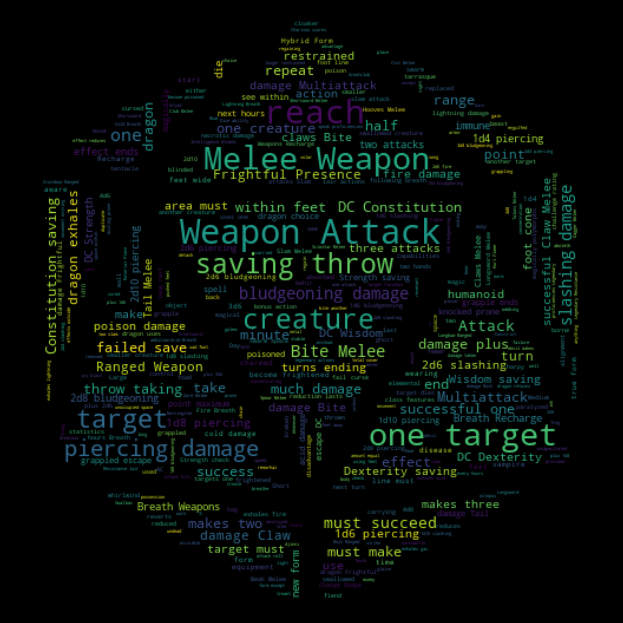

In [82]:
# Wordcloud of action words
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(action_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




In [83]:
reaction_text = " ".join(row for row in monster_df.Reactions)

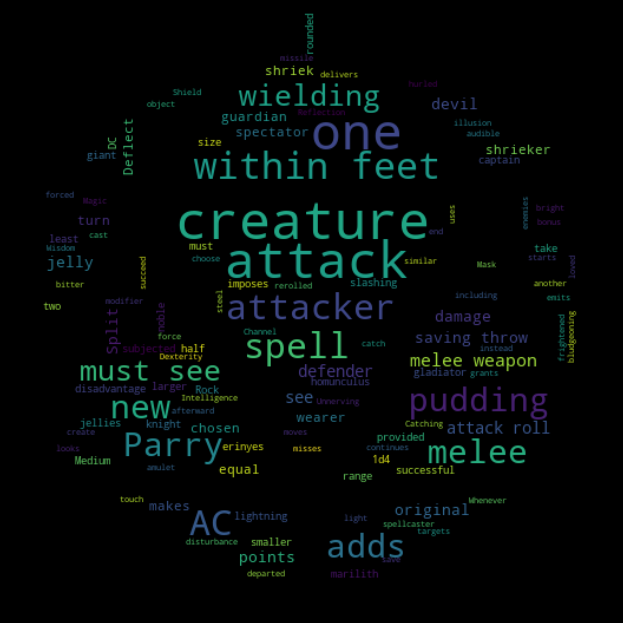

In [84]:
# Wordcloud of reaction words
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(reaction_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [85]:
# WHY ARE THERE SO MANY PUDDING REACTIONS
monster_df[monster_df['Reactions'].str.contains("pudding")]['Reactions']
#The reaction just used the word pudding a lot

7    ["Split. When a pudding that is Medium or larg...
Name: Reactions, dtype: object

In [86]:
traits_text = " ".join(row for row in monster_df.Traits)

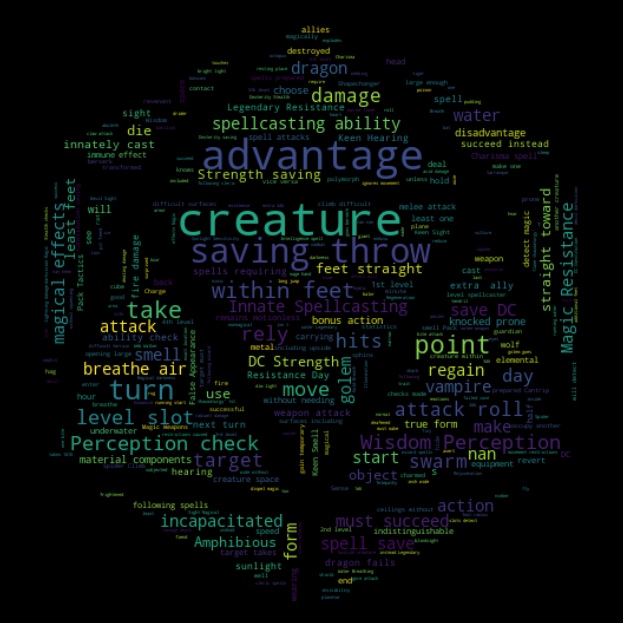

In [87]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(traits_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [88]:
legendaryaction_text = " ".join(row for row in monster_df['Legendary Actions'])

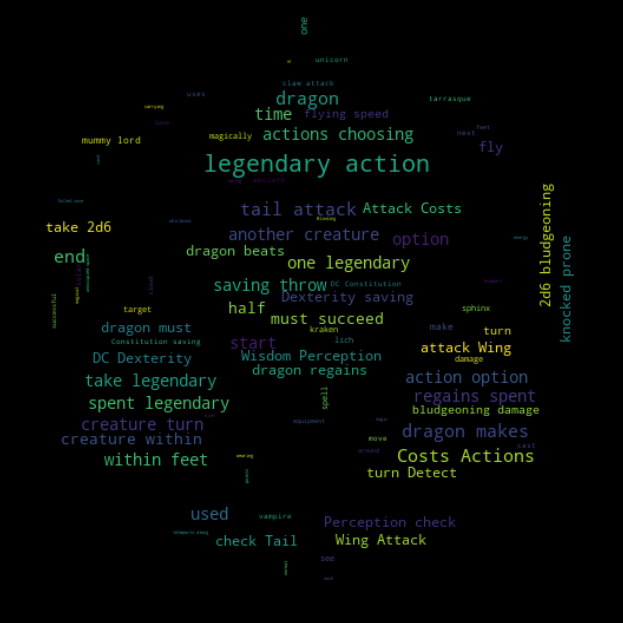

In [89]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(legendaryaction_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [90]:
# Wordcloud of all available text
monster_df['Full_Text']= monster_df[['Legendary Actions', 'Traits','Reactions','Actions']].apply(' '.join,axis=1)
all_text= " ".join(row for row in monster_df['Full_Text'])

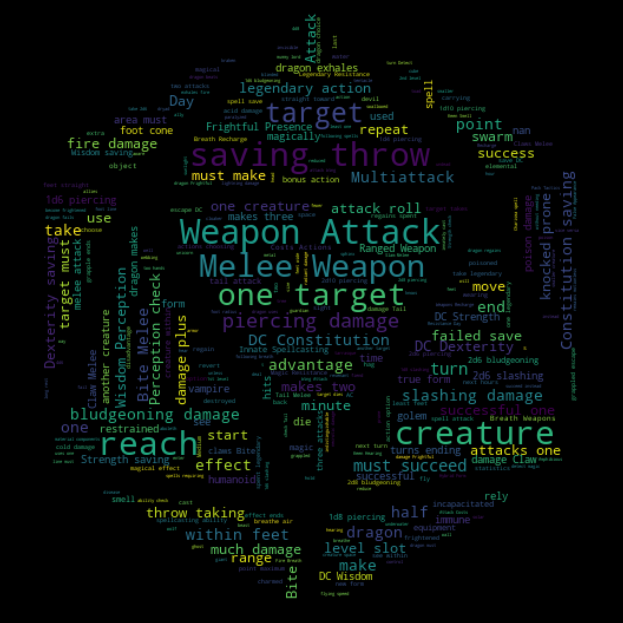

In [91]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=4000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(all_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()